# 02 - Scraping Song Lyrics
This notebook contains code for obtaining lyrics for each of Billboard's Hot 100 singles from 1959 to 2019.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bs4
import requests
import warnings
import re
import html
import unidecode

from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'arial'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

warnings.filterwarnings('ignore')

Below is the CSV created from **01 - Scraping Billboard Charts** containing Year-end Hot 100 Singles data.

In [2]:
billboard = pd.read_csv('../data/billboard.csv')
billboard.sample(5)

,index,rank,song,artist_base,artist_all,year,artist_featured
126,26,27,baby (you've got what it takes),dick and deedee,dinah washington & brook benton,1960,NaN
1055,55,56,this magic moment,jay and the americans,jay and the americans,1969,NaN
2701,0,1,that's what friends are for,dionne and friends,dionne and friends,1986,NaN
4299,98,99,hero,enrique iglesias,enrique iglesias,2001,NaN
299,99,100,please stay,the drifters,the drifters,1961,NaN


## Additional data cleaning
A few additional cleaning steps need to be made to the **artist_base** and **song** fields to help with querying for data. For artists, we replace the ampersand **&** with **and**, and for both artists and songs, we strip the text of accents, replace hyphens **-** with spaces, and remove all other punctuation.

In [3]:
def clean_song(x):
    x = x.replace('-', ' ')
    x = re.sub(r'[^\w\s]','', x)
    x = unidecode.unidecode(x)
    return x

billboard[['artist_base']]\
    = billboard[['artist_base']].applymap(
        lambda x: x.replace('&', 'and'))

billboard[['song_clean', 'artist_clean']]\
    = billboard[['song', 'artist_base']].applymap(clean_song)

billboard.sample(5)

,index,rank,song,artist_base,artist_all,year,artist_featured,song_clean,artist_clean
1626,25,26,boogie on reggae woman,stevie wonder,stevie wonder,1975,NaN,boogie on reggae woman,stevie wonder
1099,99,100,sweet cream ladies,the box tops,the box tops,1969,NaN,sweet cream ladies,the box tops
4104,3,4,i wanna know,joe,joe,2000,NaN,i wanna know,joe
1520,19,20,hooked on a feeling,blue swede,blue swede,1974,NaN,hooked on a feeling,blue swede
5241,40,41,6 foot 7 foot,lil wayne,lil wayne featuring cory gunz,2011,cory gunz,6 foot 7 foot,lil wayne


## Obtaining lyrics
There exist many API's for accessing song lyrics, but many require a fee, and those that do not tend to be unstable or not include a sufficiently comprehensive database of songs. Instead, we scrape from four websites' URL's directly. For each website, a page of lyrics can be obtained through some modified URL comprising of the song and artist names. The websites are scraped sequentially in the following order until a successful scrape has occurred or all URL's have been tried:

1. [www.genius.com](www.genius.com)
2. [www.songlyrics.com](www.songlyrics.com)
3. [www.lyricsmode.com](www.lyricsmode.com)
4. [www.metrolyrics.com](www.metrolyrics.com)

Many bands have names beginning with _The_, which no website handles consistently; sometimes the article is included in the url, other times it is omitted. For this reason, if an artist with _The_ in its name fails the first round of queries, the same name with _The_ removed is used for a second round.

In [4]:
lyrics_list = list() # collector for lyric strings or None if no lyrics found
source_list = list() # collector for the URL from which lyrics were obtained

for index, row in billboard.iterrows():
    artist = row['artist_clean']
    artist_2 = re.sub(r'^the ', '', row['artist_clean']) # if initial round fails
    song = row['song_clean']
    source = None
    
    # generate URLs for each website. some uses dashes in place of 
    # whitespaces, others use underscores
    urls = list()
    metro_url = 'http://metrolyrics.com/{}-lyrics-{}.html'.format(
        song.replace(' ', '-'), artist.replace(' ', '-'))
    song_url = 'http://songlyrics.com/{}/{}-lyrics/'.format(
        artist.replace(' ', '-'), song.replace(' ', '-'))
    mode_url = 'http://www.lyricsmode.com/lyrics/{}/{}/{}.html'.format(
        artist[0], artist.replace(' ', '_'), song.replace(' ', '_'))
    genius_url = 'https://genius.com/{}-{}-lyrics'.format(
        artist.replace(' ', '-'), song.replace(' ', '-'))
    urls.extend([genius_url, song_url, mode_url, metro_url])
    if artist != artist_2:
        genius_url = 'https://genius.com/{}-{}-lyrics'.format(
            artist_2.replace(' ', '-'), song.replace(' ', '-'))
        metro_url = 'http://metrolyrics.com/{}-lyrics-{}.html'.format(
                song.replace(' ', '-'), artist_2.replace(' ', '-'))
        song_url = 'http://songlyrics.com/{}/{}-lyrics/'.format(
            artist_2.replace(' ', '-'), song.replace(' ', '-'))
        mode_url = 'http://www.lyricsmode.com/lyrics/{}/{}/{}.html'.format(
            artist_2[0], artist_2.replace(' ', '_'), song.replace(' ', '_'))
        urls.extend([genius_url, song_url, mode_url, metro_url])
    
    # attempt scrape and parse sequence. lyrics collected as list of tokens.
    for url in urls:
        try:
            # request HTML and parse
            html = requests.get(url=url).content
            soup = bs4.BeautifulSoup(html)
            
            # find lyrics and pre-process
            if 'genius.com' in url:
                print(url)
                lyrics = soup\
                    .find('div', {'class': 'lyrics'})\
                    .find('p')\
                    .findAll(text=True)
                if lyrics is None:
                    raise Exception
                source = 'genius.com'
                
            # for songlyrics.com, if no lyrics found, a message is displayed
            # where lyrics would be. thus, we check for this message instead.
            if 'songlyrics' in url:
                print(url)
                lyrics = soup\
                    .find('p', {'id': 'songLyricsDiv'})\
                    .findAll(text=True)
                if 'Sorry, we have no ' in lyrics[0]:
                    lyrics = None
                    raise Exception
                source = 'songlyrics.com'
            if 'lyricsmode' in url:
                print(url)
                lyrics = soup.find('p', {'id': 'lyrics_text'})
                if lyrics is None:
                    raise Exception
                lyrics = lyrics.text.split()
                source = 'lyricsmode.com'
            if 'metrolyrics' in url:
                print(url)
                lyrics = soup.find('div', {'id': 'lyrics-body-text'})
                if lyrics is None:
                    raise Exception
                lyrics = [line.findAll(text=True)\
                          for line in soup.findAll('p', {'class': 'verse'})]
                lyrics = [item for sublist in lyrics for item in sublist]
                source = 'metrolyrics.com'
            
#             # pre-processing below only occurs if query successful
#             lyrics = ' '.join(lyrics).lower().replace('\n', '')
            
#             # remove apostrophes
#             lyrics = lyrics.replace('\'', '')
            
#             # remove song structure tags in square brackets
#             lyrics = re.sub(r'\[.*\]' , ' ', lyrics)
            
#             # all other punctuations replaced with spaces
#             lyrics = re.sub(r'[^\w\s]', ' ', lyrics)
            
#             # replace consecutive whitespaces with single space
#             lyrics = re.sub(r'\s+', ' ', lyrics)
            
            break
        except:
            print('error')
    lyrics_list.append(lyrics)
    source_list.append(source)

https://genius.com/johnny-horton-the-battle-of-new-orleans-lyrics
https://genius.com/bobby-darin-mack-the-knife-lyrics
error
http://songlyrics.com/bobby-darin/mack-the-knife-lyrics/
https://genius.com/lloyd-price-personality-lyrics
https://genius.com/frankie-avalon-venus-lyrics
https://genius.com/paul-anka-lonely-boy-lyrics
https://genius.com/bobby-darin-dream-lover-lyrics
error
http://songlyrics.com/bobby-darin/dream-lover-lyrics/
https://genius.com/the-browns-the-three-bells-lyrics
https://genius.com/the-fleetwoods-come-softly-to-me-lyrics
https://genius.com/wilbert-harrison-kansas-city-lyrics
https://genius.com/the-fleetwoods-mr-blue-lyrics
https://genius.com/santo-and-johnny-sleep-walk-lyrics
error
http://songlyrics.com/santo-and-johnny/sleep-walk-lyrics/
error
http://www.lyricsmode.com/lyrics/s/santo_and_johnny/sleep_walk.html
error
http://metrolyrics.com/sleep-walk-lyrics-santo-and-johnny.html
error
https://genius.com/paul-anka-put-your-head-on-my-shoulder-lyrics
https://genius.c

error
http://www.lyricsmode.com/lyrics/w/wink_martindale/the_deck_of_cards.html
error
http://metrolyrics.com/the-deck-of-cards-lyrics-wink-martindale.html
error
https://genius.com/clyde-mcphatter-a-lovers-question-lyrics
error
http://songlyrics.com/clyde-mcphatter/a-lovers-question-lyrics/
https://genius.com/the-flamingos-i-only-have-eyes-for-you-lyrics
error
http://songlyrics.com/the-flamingos/i-only-have-eyes-for-you-lyrics/
https://genius.com/ricky-nelson-its-late-lyrics
https://genius.com/chris-barber-petite-fleur-lyrics
error
http://songlyrics.com/chris-barber/petite-fleur-lyrics/
https://genius.com/annette-funicello-tall-paul-lyrics
error
http://songlyrics.com/annette-funicello/tall-paul-lyrics/
https://genius.com/the-kingston-trio-the-tijuana-jail-lyrics
error
http://songlyrics.com/the-kingston-trio/the-tijuana-jail-lyrics/
https://genius.com/ricky-nelson-just-a-little-too-much-lyrics
https://genius.com/jack-scott-goodbye-baby-lyrics
https://genius.com/the-coasters-along-came-jo

http://metrolyrics.com/mr-custer-lyrics-larry-verne.html
error
https://genius.com/brenda-lee-i-want-to-be-wanted-lyrics
https://genius.com/the-fendermen-mule-skinner-blues-lyrics
error
http://songlyrics.com/the-fendermen/mule-skinner-blues-lyrics/
https://genius.com/johnny-preston-cradle-of-love-lyrics
error
http://songlyrics.com/johnny-preston/cradle-of-love-lyrics/
https://genius.com/dion-you-got-what-it-takes-lyrics
error
http://songlyrics.com/dion/you-got-what-it-takes-lyrics/
error
http://www.lyricsmode.com/lyrics/d/dion/you_got_what_it_takes.html
error
http://metrolyrics.com/you-got-what-it-takes-lyrics-dion.html
error
https://genius.com/hank-locklin-please-help-me-im-falling-lyrics
error
http://songlyrics.com/hank-locklin/please-help-me-im-falling-lyrics/
https://genius.com/ron-holden-love-you-so-lyrics
error
http://songlyrics.com/ron-holden/love-you-so-lyrics/
https://genius.com/hank-ballard-finger-poppin-time-lyrics
error
http://songlyrics.com/hank-ballard/finger-poppin-time-l

http://www.lyricsmode.com/lyrics/t/the_mar_keys/last_night.html
error
http://metrolyrics.com/last-night-lyrics-the-mar-keys.html
error
https://genius.com/mar-keys-last-night-lyrics
error
http://songlyrics.com/mar-keys/last-night-lyrics/
https://genius.com/the-shirelles-will-you-love-me-tomorrow-lyrics
error
http://songlyrics.com/the-shirelles/will-you-love-me-tomorrow-lyrics/
https://genius.com/ferrante-and-teicher-exodus-lyrics
https://genius.com/connie-francis-where-the-boys-are-lyrics
error
http://songlyrics.com/connie-francis/where-the-boys-are-lyrics/
https://genius.com/ray-charles-hit-the-road-jack-lyrics
https://genius.com/sue-thompson-sad-movies-make-me-cry-lyrics
error
http://songlyrics.com/sue-thompson/sad-movies-make-me-cry-lyrics/
https://genius.com/ernie-k-doe-mother-in-law-lyrics
https://genius.com/the-dovells-bristol-stomp-lyrics
https://genius.com/ricky-nelson-travelin-man-lyrics
error
http://songlyrics.com/ricky-nelson/travelin-man-lyrics/
https://genius.com/the-miracl

http://songlyrics.com/adam-wade/the-writing-on-the-wall-lyrics/
https://genius.com/dick-and-deedee-my-kind-of-girl-lyrics
error
http://songlyrics.com/dick-and-deedee/my-kind-of-girl-lyrics/
error
http://www.lyricsmode.com/lyrics/d/dick_and_deedee/my_kind_of_girl.html
error
http://metrolyrics.com/my-kind-of-girl-lyrics-dick-and-deedee.html
error
https://genius.com/paul-anka-tonight-my-love-tonight-lyrics
https://genius.com/dion-san-antonio-rose-lyrics
error
http://songlyrics.com/dion/san-antonio-rose-lyrics/
error
http://www.lyricsmode.com/lyrics/d/dion/san_antonio_rose.html
error
http://metrolyrics.com/san-antonio-rose-lyrics-dion.html
error
https://genius.com/jimmy-dean-big-bad-john-lyrics
https://genius.com/bobby-rydell-good-time-baby-lyrics
error
http://songlyrics.com/bobby-rydell/good-time-baby-lyrics/
https://genius.com/bobby-vee-rubber-ball-lyrics
error
http://songlyrics.com/bobby-vee/rubber-ball-lyrics/
https://genius.com/ray-peterson-missing-you-lyrics
https://genius.com/brenda

http://songlyrics.com/the-corsairs/smoky-places-lyrics/
https://genius.com/sam-cooke-having-a-party-lyrics
error
http://songlyrics.com/sam-cooke/having-a-party-lyrics/
https://genius.com/booker-t-and-the-mgs-green-onions-lyrics
error
http://songlyrics.com/booker-t-and-the-mgs/green-onions-lyrics/
error
http://www.lyricsmode.com/lyrics/b/booker_t_and_the_mgs/green_onions.html
error
http://metrolyrics.com/green-onions-lyrics-booker-t-and-the-mgs.html
https://genius.com/ray-charles-you-dont-know-me-lyrics
error
http://songlyrics.com/ray-charles/you-dont-know-me-lyrics/
https://genius.com/the-four-seasons-sherry-lyrics
error
http://songlyrics.com/the-four-seasons/sherry-lyrics/
https://genius.com/joanie-sommers-johnny-get-angry-lyrics
error
http://songlyrics.com/joanie-sommers/johnny-get-angry-lyrics/
https://genius.com/elvis-presley-cant-help-falling-in-love-lyrics
https://genius.com/joey-dee-and-the-starliters-shout-lyrics
https://genius.com/dave-baby-cortez-rinky-dink-lyrics
error
http:

http://songlyrics.com/peggy-march/i-will-follow-him-lyrics/
https://genius.com/the-chantays-pipeline-lyrics
https://genius.com/jan-and-dean-surf-city-lyrics
https://genius.com/lesley-gore-its-my-party-lyrics
https://genius.com/eydie-gorme-blame-it-on-the-bossa-nova-lyrics
error
http://songlyrics.com/eydie-gorme/blame-it-on-the-bossa-nova-lyrics/
https://genius.com/the-dovells-you-cant-sit-down-lyrics
error
http://songlyrics.com/the-dovells/you-cant-sit-down-lyrics/
https://genius.com/martha-and-the-vandellas-heat-wave-lyrics
error
error
error
http://metrolyrics.com/heat-wave-lyrics-martha-and-the-vandellas.html
error
https://genius.com/randy-and-the-rainbows-denise-lyrics
error
http://songlyrics.com/randy-and-the-rainbows/denise-lyrics/
https://genius.com/the-rooftop-singers-walk-right-in-lyrics
error
http://songlyrics.com/the-rooftop-singers/walk-right-in-lyrics/
https://genius.com/jimmy-soul-if-you-wanna-be-happy-lyrics
https://genius.com/trini-lopez-if-i-had-a-hammer-lyrics
error
ht

https://genius.com/joe-harnell-fly-me-to-the-moon-lyrics
error
http://songlyrics.com/joe-harnell/fly-me-to-the-moon-lyrics/
error
http://www.lyricsmode.com/lyrics/j/joe_harnell/fly_me_to_the_moon.html
error
http://metrolyrics.com/fly-me-to-the-moon-lyrics-joe-harnell.html
error
https://genius.com/the-kingston-trio-walk-dont-run-lyrics
error
http://songlyrics.com/the-kingston-trio/walk-dont-run-lyrics/
error
http://www.lyricsmode.com/lyrics/t/the_kingston_trio/walk_dont_run.html
error
http://metrolyrics.com/walk-dont-run-lyrics-the-kingston-trio.html
error
https://genius.com/kingston-trio-walk-dont-run-lyrics
error
http://songlyrics.com/kingston-trio/walk-dont-run-lyrics/
error
http://www.lyricsmode.com/lyrics/k/kingston_trio/walk_dont_run.html
error
http://metrolyrics.com/walk-dont-run-lyrics-kingston-trio.html
error
https://genius.com/the-dartells-hot-pastrami-lyrics
error
http://songlyrics.com/the-dartells/hot-pastrami-lyrics/
https://genius.com/the-ran-dells-martian-hop-lyrics
error

http://songlyrics.com/bobby-freeman/cmon-and-swim-lyrics/
error
http://www.lyricsmode.com/lyrics/b/bobby_freeman/cmon_and_swim.html
error
http://metrolyrics.com/cmon-and-swim-lyrics-bobby-freeman.html
https://genius.com/the-beatles-do-you-want-to-know-a-secret-lyrics
error
http://songlyrics.com/the-beatles/do-you-want-to-know-a-secret-lyrics/
https://genius.com/the-impressions-keep-on-pushing-lyrics
https://genius.com/the-four-tops-baby-i-need-your-loving-lyrics
https://genius.com/diane-renay-navy-blue-lyrics
https://genius.com/the-bachelors-diane-lyrics
https://genius.com/the-marketts-out-of-limits-lyrics
error
http://songlyrics.com/the-marketts/out-of-limits-lyrics/
error
http://www.lyricsmode.com/lyrics/t/the_marketts/out_of_limits.html
error
http://metrolyrics.com/out-of-limits-lyrics-the-marketts.html
error
https://genius.com/marketts-out-of-limits-lyrics
error
http://songlyrics.com/marketts/out-of-limits-lyrics/
https://genius.com/the-hondells-little-honda-lyrics
error
http://son

http://songlyrics.com/the-supremes/stop-in-the-name-of-love-lyrics/
https://genius.com/the-righteous-brothers-unchained-melody-lyrics
https://genius.com/hermans-hermits-silhouettes-lyrics
error
http://songlyrics.com/hermans-hermits/silhouettes-lyrics/
https://genius.com/the-seekers-ill-never-find-another-you-lyrics
error
http://songlyrics.com/the-seekers/ill-never-find-another-you-lyrics/
https://genius.com/jay-and-the-americans-cara-mia-lyrics
error
http://songlyrics.com/jay-and-the-americans/cara-mia-lyrics/
error
error
http://metrolyrics.com/cara-mia-lyrics-jay-and-the-americans.html
error
https://genius.com/the-byrds-mr-tambourine-man-lyrics
https://genius.com/sounds-orchestral-cast-your-fate-to-the-wind-lyrics
https://genius.com/barbara-mason-yes-im-ready-lyrics
error
http://songlyrics.com/barbara-mason/yes-im-ready-lyrics/
error
http://www.lyricsmode.com/lyrics/b/barbara_mason/yes_im_ready.html
error
http://metrolyrics.com/yes-im-ready-lyrics-barbara-mason.html
error
https://geni

http://metrolyrics.com/just-my-style-lyrics-beau-brummels.html
error
https://genius.com/the-rolling-stones-the-last-time-lyrics
error
http://songlyrics.com/the-rolling-stones/the-last-time-lyrics/
https://genius.com/the-lovin-spoonful-do-you-believe-in-magic-lyrics
https://genius.com/cher-all-i-really-want-to-do-lyrics
error
http://songlyrics.com/cher/all-i-really-want-to-do-lyrics/
https://genius.com/little-anthony-and-the-imperials-take-me-back-lyrics
https://genius.com/the-strangeloves-i-want-candy-lyrics
error
http://songlyrics.com/the-strangeloves/i-want-candy-lyrics/
https://genius.com/the-miracles-ooo-baby-baby-lyrics
error
http://songlyrics.com/the-miracles/ooo-baby-baby-lyrics/
https://genius.com/sonny-bono-laugh-at-me-lyrics
error
http://songlyrics.com/sonny-bono/laugh-at-me-lyrics/
https://genius.com/roy-head-treat-her-right-lyrics
error
http://songlyrics.com/roy-head/treat-her-right-lyrics/
https://genius.com/jack-jones-the-race-is-on-lyrics
error
http://songlyrics.com/jack

https://genius.com/david-houston-almost-persuaded-lyrics
error
http://songlyrics.com/david-houston/almost-persuaded-lyrics/
https://genius.com/bobby-darin-if-i-were-a-carpenter-lyrics
error
http://songlyrics.com/bobby-darin/if-i-were-a-carpenter-lyrics/
https://genius.com/the-marvelettes-dont-mess-with-bill-lyrics
error
http://songlyrics.com/the-marvelettes/dont-mess-with-bill-lyrics/
https://genius.com/neil-diamond-cherry-cherry-lyrics
error
http://songlyrics.com/neil-diamond/cherry-cherry-lyrics/
https://genius.com/dionne-warwick-message-to-michael-lyrics
https://genius.com/lou-rawls-love-is-a-hurtin-thing-lyrics
error
http://songlyrics.com/lou-rawls/love-is-a-hurtin-thing-lyrics/
https://genius.com/the-shadows-of-knight-gloria-lyrics
https://genius.com/the-supremes-my-world-is-empty-without-you-lyrics
error
http://songlyrics.com/the-supremes/my-world-is-empty-without-you-lyrics/
https://genius.com/the-beach-boys-barbara-ann-lyrics
error
http://songlyrics.com/the-beach-boys/barbara-a

http://songlyrics.com/the-casinos/then-you-can-tell-me-goodbye-lyrics/
https://genius.com/the-supremes-reflections-lyrics
https://genius.com/the-hollies-on-a-carousel-lyrics
error
http://songlyrics.com/the-hollies/on-a-carousel-lyrics/
https://genius.com/bobby-vinton-please-love-me-forever-lyrics
https://genius.com/dionne-warwick-alfie-lyrics
https://genius.com/the-tremeloes-silence-is-golden-lyrics
error
http://songlyrics.com/the-tremeloes/silence-is-golden-lyrics/
https://genius.com/ed-ames-my-cup-runneth-over-lyrics
https://genius.com/the-5th-dimension-up-up-and-away-lyrics
error
http://songlyrics.com/the-5th-dimension/up-up-and-away-lyrics/
https://genius.com/scott-mckenzie-san-francisco-be-sure-to-wear-flowers-in-your-hair-lyrics
error
http://songlyrics.com/scott-mckenzie/san-francisco-be-sure-to-wear-flowers-in-your-hair-lyrics/
https://genius.com/the-cowsills-the-rain-the-park--other-things-lyrics
error
error
http://www.lyricsmode.com/lyrics/t/the_cowsills/the_rain_the_park__oth

http://songlyrics.com/cream/sunshine-of-your-love-lyrics/
https://genius.com/herb-alpert-this-guys-in-love-with-you-lyrics
error
http://songlyrics.com/herb-alpert/this-guys-in-love-with-you-lyrics/
https://genius.com/hugo-montenegro-the-good-the-bad-and-the-ugly-lyrics
error
http://songlyrics.com/hugo-montenegro/the-good-the-bad-and-the-ugly-lyrics/
https://genius.com/simon-and-garfunkel-mrs-robinson-lyrics
error
http://songlyrics.com/simon-and-garfunkel/mrs-robinson-lyrics/
https://genius.com/archie-bell-and-the-drells-tighten-up-lyrics
error
http://songlyrics.com/archie-bell-and-the-drells/tighten-up-lyrics/
https://genius.com/jeannie-c-riley-harper-valley-pta-lyrics
error
http://songlyrics.com/jeannie-c-riley/harper-valley-pta-lyrics/
https://genius.com/o-c-smith-little-green-apples-lyrics
error
http://songlyrics.com/o-c-smith/little-green-apples-lyrics/
https://genius.com/tommy-james-and-the-shondells-mony-mony-lyrics
https://genius.com/the-doors-hello-i-love-you-lyrics
error
http:

https://genius.com/the-beatles-revolution-lyrics
error
http://songlyrics.com/the-beatles/revolution-lyrics/
https://genius.com/gary-puckett-and-the-union-gap-woman-woman-lyrics
error
http://songlyrics.com/gary-puckett-and-the-union-gap/woman-woman-lyrics/
https://genius.com/the-turtles-elenore-lyrics
error
http://songlyrics.com/the-turtles/elenore-lyrics/
https://genius.com/cream-white-room-lyrics
https://genius.com/marvin-gaye-youre-all-i-need-to-get-by-lyrics
error
http://songlyrics.com/marvin-gaye/youre-all-i-need-to-get-by-lyrics/
error
http://www.lyricsmode.com/lyrics/m/marvin_gaye/youre_all_i_need_to_get_by.html
error
http://metrolyrics.com/youre-all-i-need-to-get-by-lyrics-marvin-gaye.html
https://genius.com/the-foundations-baby-now-that-ive-found-you-lyrics
error
http://songlyrics.com/the-foundations/baby-now-that-ive-found-you-lyrics/
https://genius.com/the-sweet-inspirations-sweet-inspiration-lyrics
error
http://songlyrics.com/the-sweet-inspirations/sweet-inspiration-lyrics/


http://songlyrics.com/mercy/love-can-make-you-happy-lyrics/
https://genius.com/oliver-good-morning-starshine-lyrics
https://genius.com/the-guess-who-these-eyes-lyrics
error
http://songlyrics.com/the-guess-who/these-eyes-lyrics/
https://genius.com/blood-sweat-and-tears-youve-made-me-so-very-happy-lyrics
error
error
http://www.lyricsmode.com/lyrics/b/blood_sweat_and_tears/youve_made_me_so_very_happy.html
error
http://metrolyrics.com/youve-made-me-so-very-happy-lyrics-blood-sweat-and-tears.html
error
https://genius.com/jackie-deshannon-put-a-little-love-in-your-heart-lyrics
https://genius.com/charles-wright-and-the-watts-103rd-street-rhythm-band-do-your-thing-lyrics
https://genius.com/the-grass-roots-id-wait-a-million-years-lyrics
error
http://songlyrics.com/the-grass-roots/id-wait-a-million-years-lyrics/
https://genius.com/the-doors-touch-me-lyrics
https://genius.com/spiral-starecase-more-today-than-yesterday-lyrics
error
http://songlyrics.com/spiral-starecase/more-today-than-yesterday-l

https://genius.com/the-jackson-5-abc-lyrics
https://genius.com/the-jackson-5-the-love-you-save-lyrics
error
http://songlyrics.com/the-jackson-5/the-love-you-save-lyrics/
https://genius.com/neil-diamond-cracklin-rosie-lyrics
error
http://songlyrics.com/neil-diamond/cracklin-rosie-lyrics/
https://genius.com/tony-orlando-and-dawn-candida-lyrics
https://genius.com/sly-and-the-family-stone-thank-you-falettinme-be-mice-elf-agin-lyrics
https://genius.com/eric-burdon-spill-the-wine-lyrics
https://genius.com/five-stairsteps-o-o-h-child-lyrics
error
error
http://www.lyricsmode.com/lyrics/f/five_stairsteps/o_o_h_child.html
error
http://metrolyrics.com/o-o-h-child-lyrics-five-stairsteps.html
error
https://genius.com/norman-greenbaum-spirit-in-the-sky-lyrics
error
http://songlyrics.com/norman-greenbaum/spirit-in-the-sky-lyrics/
https://genius.com/melanie-safka-lay-down-candles-in-the-rain-lyrics
error
http://songlyrics.com/melanie-safka/lay-down-candles-in-the-rain-lyrics/
https://genius.com/the-te

https://genius.com/temptations-i-am-i-said-lyrics
error
http://songlyrics.com/temptations/i-am-i-said-lyrics/
error
http://www.lyricsmode.com/lyrics/t/temptations/i_am_i_said.html
error
http://metrolyrics.com/i-am-i-said-lyrics-temptations.html
error
https://genius.com/tom-jones-without-love-there-is-nothing-lyrics
https://genius.com/pacific-gas-and-electric-dont-knock-my-love-part-1-lyrics
error
http://songlyrics.com/pacific-gas-and-electric/dont-knock-my-love-part-1-lyrics/
error
http://www.lyricsmode.com/lyrics/p/pacific_gas_and_electric/dont_knock_my_love_part_1.html
error
http://metrolyrics.com/dont-knock-my-love-part-1-lyrics-pacific-gas-and-electric.html
error
https://genius.com/crosby-stills-nash-and-young-woodstock-lyrics
https://genius.com/dionne-warwick-ill-never-fall-in-love-again-lyrics
error
http://songlyrics.com/dionne-warwick/ill-never-fall-in-love-again-lyrics/
https://genius.com/the-new-seekers-look-what-theyve-done-to-my-song-ma-lyrics
error
http://songlyrics.com/the

http://www.lyricsmode.com/lyrics/t/the_partridge_family/doesnt_somebody_want_to_be_wanted.html
error
http://metrolyrics.com/doesnt-somebody-want-to-be-wanted-lyrics-the-partridge-family.html
https://genius.com/tommy-james-draggin-the-line-lyrics
error
http://songlyrics.com/tommy-james/draggin-the-line-lyrics/
https://genius.com/ike-and-tina-turner-proud-mary-lyrics
error
error
http://www.lyricsmode.com/lyrics/i/ike_and_tina_turner/proud_mary.html
error
http://metrolyrics.com/proud-mary-lyrics-ike-and-tina-turner.html
error
https://genius.com/chicago-beginnings-lyrics
error
http://songlyrics.com/chicago/beginnings-lyrics/
https://genius.com/the-bells-stay-awhile-lyrics
https://genius.com/the-stampeders-sweet-city-woman-lyrics
error
error
http://www.lyricsmode.com/lyrics/t/the_stampeders/sweet_city_woman.html
error
http://metrolyrics.com/sweet-city-woman-lyrics-the-stampeders.html
error
https://genius.com/stampeders-sweet-city-woman-lyrics
error
http://songlyrics.com/stampeders/sweet-cit

https://genius.com/robert-john-the-lion-sleeps-tonight-lyrics
error
http://songlyrics.com/robert-john/the-lion-sleeps-tonight-lyrics/
https://genius.com/billy-preston-outa-space-lyrics
https://genius.com/war-slippin-into-darkness-lyrics
error
http://songlyrics.com/war/slippin-into-darkness-lyrics/
https://genius.com/the-hollies-long-cool-woman-in-a-black-dress-lyrics
error
http://songlyrics.com/the-hollies/long-cool-woman-in-a-black-dress-lyrics/
https://genius.com/mouth-and-macneal-how-do-you-do-lyrics
https://genius.com/neil-diamond-song-sung-blue-lyrics
https://genius.com/america-a-horse-with-no-name-lyrics
https://genius.com/hot-butter-popcorn-lyrics
error
http://songlyrics.com/hot-butter/popcorn-lyrics/
https://genius.com/the-main-ingredient-everybody-plays-the-fool-lyrics
https://genius.com/climax-precious-and-few-lyrics
https://genius.com/the-5th-dimension-last-night-i-didnt-get-to-sleep-at-all-lyrics
error
http://songlyrics.com/the-5th-dimension/last-night-i-didnt-get-to-sleep-

http://songlyrics.com/don-mclean/vincent-lyrics/
https://genius.com/the-detroit-emeralds-baby-let-me-take-you-in-my-arms-lyrics
error
http://songlyrics.com/the-detroit-emeralds/baby-let-me-take-you-in-my-arms-lyrics/
https://genius.com/rick-springfield-speak-to-the-sky-lyrics
error
http://songlyrics.com/rick-springfield/speak-to-the-sky-lyrics/
https://genius.com/the-hillside-singers-id-like-to-teach-the-world-to-sing-in-perfect-harmony-lyrics
error
http://songlyrics.com/the-hillside-singers/id-like-to-teach-the-world-to-sing-in-perfect-harmony-lyrics/
error
http://www.lyricsmode.com/lyrics/t/the_hillside_singers/id_like_to_teach_the_world_to_sing_in_perfect_harmony.html
error
http://metrolyrics.com/id-like-to-teach-the-world-to-sing-in-perfect-harmony-lyrics-the-hillside-singers.html
error
https://genius.com/hillside-singers-id-like-to-teach-the-world-to-sing-in-perfect-harmony-lyrics
error
http://songlyrics.com/hillside-singers/id-like-to-teach-the-world-to-sing-in-perfect-harmony-ly

http://songlyrics.com/johnnie-taylor/i-believe-in-you-you-believe-in-me-lyrics/
https://genius.com/the-carpenters-sing-lyrics
error
http://songlyrics.com/the-carpenters/sing-lyrics/
https://genius.com/the-four-tops-aint-no-woman-like-the-one-ive-got-lyrics
https://genius.com/eric-weissberg-dueling-banjos-lyrics
https://genius.com/stevie-wonder-higher-ground-lyrics
https://genius.com/al-green-here-i-am-come-and-take-me-lyrics
error
http://songlyrics.com/al-green/here-i-am-come-and-take-me-lyrics/
https://genius.com/bw-stevenson-my-maria-lyrics
error
http://songlyrics.com/bw-stevenson/my-maria-lyrics/
error
http://www.lyricsmode.com/lyrics/b/bw_stevenson/my_maria.html
error
http://metrolyrics.com/my-maria-lyrics-bw-stevenson.html
https://genius.com/curtis-mayfield-superfly-lyrics
error
http://songlyrics.com/curtis-mayfield/superfly-lyrics/
https://genius.com/edward-bear-last-song-lyrics
error
http://songlyrics.com/edward-bear/last-song-lyrics/
https://genius.com/gilbert-osullivan-get-dow

https://genius.com/the-main-ingredient-just-dont-want-to-be-lonely-lyrics
https://genius.com/billy-preston-nothing-from-nothing-lyrics
error
http://songlyrics.com/billy-preston/nothing-from-nothing-lyrics/
https://genius.com/george-mccrae-rock-your-baby-lyrics
https://genius.com/the-carpenters-top-of-the-world-lyrics
error
http://songlyrics.com/the-carpenters/top-of-the-world-lyrics/
https://genius.com/steve-miller-band-the-joker-lyrics
error
http://songlyrics.com/steve-miller-band/the-joker-lyrics/
https://genius.com/gladys-knight-and-the-pips-ive-got-to-use-my-imagination-lyrics
error
http://songlyrics.com/gladys-knight-and-the-pips/ive-got-to-use-my-imagination-lyrics/
error
error
http://metrolyrics.com/ive-got-to-use-my-imagination-lyrics-gladys-knight-and-the-pips.html
https://genius.com/three-dog-night-the-show-must-go-on-lyrics
error
http://songlyrics.com/three-dog-night/the-show-must-go-on-lyrics/
https://genius.com/the-hues-corporation-rock-the-boat-lyrics
error
http://songlyr

https://genius.com/john-denver-thank-god-im-a-country-boy-lyrics
error
http://songlyrics.com/john-denver/thank-god-im-a-country-boy-lyrics/
https://genius.com/bee-gees-jive-talkin-lyrics
https://genius.com/eagles-best-of-my-love-lyrics
error
http://songlyrics.com/eagles/best-of-my-love-lyrics/
https://genius.com/minnie-riperton-lovin-you-lyrics
error
http://songlyrics.com/minnie-riperton/lovin-you-lyrics/
https://genius.com/carl-douglas-kung-fu-fighting-lyrics
https://genius.com/the-doobie-brothers-black-water-lyrics
error
http://songlyrics.com/the-doobie-brothers/black-water-lyrics/
https://genius.com/the-sweet-the-ballroom-blitz-lyrics
error
http://songlyrics.com/the-sweet/the-ballroom-blitz-lyrics/
https://genius.com/bj-thomas-hey-wont-you-play-another-somebody-done-somebody-wrong-song-lyrics
https://genius.com/tony-orlando-and-dawn-he-dont-love-you-like-i-love-you-lyrics
https://genius.com/janis-ian-at-seventeen-lyrics
https://genius.com/average-white-band-pick-up-the-pieces-lyrics

https://genius.com/tavares-it-only-takes-a-minute-lyrics
https://genius.com/ringo-starr-no-no-song-lyrics
error
http://songlyrics.com/ringo-starr/no-no-song-lyrics/
https://genius.com/wings-juniors-farm-lyrics
error
http://songlyrics.com/wings/juniors-farm-lyrics/
https://genius.com/jethro-tull-bungle-in-the-jungle-lyrics
https://genius.com/leo-sayer-long-tall-glasses-i-can-dance-lyrics
error
http://songlyrics.com/leo-sayer/long-tall-glasses-i-can-dance-lyrics/
https://genius.com/ray-stevens-misty-lyrics
error
http://songlyrics.com/ray-stevens/misty-lyrics/
https://genius.com/elton-john-someone-saved-my-life-tonight-lyrics
https://genius.com/neil-sedaka-bad-blood-lyrics
https://genius.com/the-carpenters-only-yesterday-lyrics
https://genius.com/dwight-twilley-im-on-fire-lyrics
https://genius.com/ringo-starr-only-you-and-you-alone-lyrics
https://genius.com/amazing-rhythm-aces-third-rate-romance-lyrics
https://genius.com/bachmanturner-overdrive-you-aint-seen-nothing-yet-lyrics
https://gen

http://www.lyricsmode.com/lyrics/d/david_dundas/wake_up_everybody.html
error
http://metrolyrics.com/wake-up-everybody-lyrics-david-dundas.html
error
https://genius.com/war-summer-lyrics
error
http://songlyrics.com/war/summer-lyrics/
https://genius.com/john-travolta-let-her-in-lyrics
https://genius.com/the-sweet-fox-on-the-run-lyrics
error
http://songlyrics.com/the-sweet/fox-on-the-run-lyrics/
https://genius.com/fleetwood-mac-rhiannon-lyrics
error
http://songlyrics.com/fleetwood-mac/rhiannon-lyrics/
https://genius.com/the-beatles-got-to-get-you-into-my-life-lyrics
error
http://songlyrics.com/the-beatles/got-to-get-you-into-my-life-lyrics/
https://genius.com/bee-gees-fanny-be-tender-with-my-love-lyrics
https://genius.com/earth-wind-and-fire-getaway-lyrics
error
http://songlyrics.com/earth-wind-and-fire/getaway-lyrics/
https://genius.com/hall-and-oates-shes-gone-lyrics
error
error
http://www.lyricsmode.com/lyrics/h/hall_and_oates/shes_gone.html
error
http://metrolyrics.com/shes-gone-lyric

http://songlyrics.com/fleetwood-mac/dont-stop-lyrics/
https://genius.com/heart-barracuda-lyrics
error
http://songlyrics.com/heart/barracuda-lyrics/
https://genius.com/the-brothers-johnson-strawberry-letter-23-lyrics
https://genius.com/bob-seger-night-moves-lyrics
error
http://songlyrics.com/bob-seger/night-moves-lyrics/
https://genius.com/helen-reddy-youre-my-world-lyrics
error
http://songlyrics.com/helen-reddy/youre-my-world-lyrics/
error
http://www.lyricsmode.com/lyrics/h/helen_reddy/youre_my_world.html
error
http://metrolyrics.com/youre-my-world-lyrics-helen-reddy.html
https://genius.com/the-marshall-tucker-band-heard-it-in-a-love-song-lyrics
error
http://songlyrics.com/the-marshall-tucker-band/heard-it-in-a-love-song-lyrics/
https://genius.com/kansas-carry-on-wayward-son-lyrics
https://genius.com/eagles-new-kid-in-town-lyrics
error
http://songlyrics.com/eagles/new-kid-in-town-lyrics/
https://genius.com/barbra-streisand-my-heart-belongs-to-me-lyrics
error
http://songlyrics.com/barbr

http://songlyrics.com/dan-hill/sometimes-when-we-touch-lyrics/
https://genius.com/donna-summer-last-dance-lyrics
error
http://songlyrics.com/donna-summer/last-dance-lyrics/
https://genius.com/olivia-newton-john-hopelessly-devoted-to-you-lyrics
https://genius.com/foreigner-hot-blooded-lyrics
https://genius.com/rod-stewart-youre-in-my-heart-the-final-acclaim-lyrics
https://genius.com/roberta-flack-the-closer-i-get-to-you-lyrics
error
http://songlyrics.com/roberta-flack/the-closer-i-get-to-you-lyrics/
https://genius.com/kansas-dust-in-the-wind-lyrics
https://genius.com/walter-egan-magnet-and-steel-lyrics
https://genius.com/randy-newman-short-people-lyrics
https://genius.com/the-ojays-use-ta-be-my-girl-lyrics
https://genius.com/natalie-cole-our-love-lyrics
error
http://songlyrics.com/natalie-cole/our-love-lyrics/
https://genius.com/pablo-cruise-love-will-find-a-way-lyrics
https://genius.com/andy-gibb-an-everlasting-love-lyrics
error
http://songlyrics.com/andy-gibb/an-everlasting-love-lyric

http://songlyrics.com/blondie/heart-of-glass-lyrics/
https://genius.com/the-doobie-brothers-what-a-fool-believes-lyrics
error
http://songlyrics.com/the-doobie-brothers/what-a-fool-believes-lyrics/
https://genius.com/chic-good-times-lyrics
error
http://songlyrics.com/chic/good-times-lyrics/
https://genius.com/neil-diamond-you-dont-bring-me-flowers-lyrics
error
error
http://www.lyricsmode.com/lyrics/n/neil_diamond/you_dont_bring_me_flowers.html
error
http://metrolyrics.com/you-dont-bring-me-flowers-lyrics-neil-diamond.html
https://genius.com/amii-stewart-knock-on-wood-lyrics
error
http://songlyrics.com/amii-stewart/knock-on-wood-lyrics/
https://genius.com/suzi-quatro-stumblin-in-lyrics
https://genius.com/maxine-nightingale-lead-me-on-lyrics
error
http://songlyrics.com/maxine-nightingale/lead-me-on-lyrics/
https://genius.com/the-jackson-5-shake-your-body-down-to-the-ground-lyrics
error
http://songlyrics.com/the-jackson-5/shake-your-body-down-to-the-ground-lyrics/
https://genius.com/meliss

http://songlyrics.com/bob-seger/weve-got-tonight-lyrics/
error
error
http://metrolyrics.com/weve-got-tonight-lyrics-bob-seger.html
https://genius.com/van-halen-dance-the-night-away-lyrics
https://genius.com/nigel-olsson-dancin-shoes-lyrics
error
http://songlyrics.com/nigel-olsson/dancin-shoes-lyrics/
error
http://www.lyricsmode.com/lyrics/n/nigel_olsson/dancin_shoes.html
error
http://metrolyrics.com/dancin-shoes-lyrics-nigel-olsson.html
error
https://genius.com/diana-ross-the-boss-lyrics
error
http://songlyrics.com/diana-ross/the-boss-lyrics/
https://genius.com/commodores-sail-on-lyrics
error
http://songlyrics.com/commodores/sail-on-lyrics/
https://genius.com/gq-i-do-love-you-lyrics
error
http://songlyrics.com/gq/i-do-love-you-lyrics/
https://genius.com/firefall-strange-way-lyrics
https://genius.com/blondie-call-me-lyrics
https://genius.com/pink-floyd-another-brick-in-the-wall-part-ii-lyrics
https://genius.com/olivia-newton-john-magic-lyrics
error
http://songlyrics.com/olivia-newton-jo

https://genius.com/peaches-and-herb-i-pledge-my-love-lyrics
https://genius.com/eagles-the-long-run-lyrics
https://genius.com/mickey-gilley-stand-by-me-lyrics
error
http://songlyrics.com/mickey-gilley/stand-by-me-lyrics/
https://genius.com/pat-benatar-heartbreaker-lyrics
error
http://songlyrics.com/pat-benatar/heartbreaker-lyrics/
https://genius.com/dionne-warwick-deja-vu-lyrics
error
http://songlyrics.com/dionne-warwick/deja-vu-lyrics/
https://genius.com/eddie-rabbitt-drivin-my-life-away-lyrics
https://genius.com/supertramp-take-the-long-way-home-lyrics
https://genius.com/fleetwood-mac-sara-lyrics
error
http://songlyrics.com/fleetwood-mac/sara-lyrics/
https://genius.com/hall-and-oates-wait-for-me-lyrics
error
http://songlyrics.com/hall-and-oates/wait-for-me-lyrics/
https://genius.com/boz-scaggs-jojo-lyrics
error
http://songlyrics.com/boz-scaggs/jojo-lyrics/
https://genius.com/hall-and-oates-youve-lost-that-lovin-feeling-lyrics
https://genius.com/george-benson-give-me-the-night-lyrics
e

https://genius.com/neil-diamond-hello-again-lyrics
https://genius.com/the-police-dont-stand-so-close-to-me-lyrics
error
http://songlyrics.com/the-police/dont-stand-so-close-to-me-lyrics/
https://genius.com/steely-dan-hey-nineteen-lyrics
error
http://songlyrics.com/steely-dan/hey-nineteen-lyrics/
https://genius.com/stevie-wonder-i-aint-gonna-stand-for-it-lyrics
https://genius.com/george-harrison-all-those-years-ago-lyrics
https://genius.com/eddie-rabbitt-step-by-step-lyrics
error
http://songlyrics.com/eddie-rabbitt/step-by-step-lyrics/
https://genius.com/billy-squier-the-stroke-lyrics
error
http://songlyrics.com/billy-squier/the-stroke-lyrics/
https://genius.com/alabama-feels-so-right-lyrics
https://genius.com/stanley-clarke-sweet-baby-lyrics
error
http://songlyrics.com/stanley-clarke/sweet-baby-lyrics/
https://genius.com/dan-fogelberg-same-old-lang-syne-lyrics
https://genius.com/pablo-cruise-cool-love-lyrics
https://genius.com/electric-light-orchestra-hold-on-tight-lyrics
https://geniu

https://genius.com/diana-ross-why-do-fools-fall-in-love-lyrics
https://genius.com/alabama-love-in-the-first-degree-lyrics
error
http://songlyrics.com/alabama/love-in-the-first-degree-lyrics/
https://genius.com/royal-philharmonic-orchestra-hooked-on-classics-lyrics
error
http://songlyrics.com/royal-philharmonic-orchestra/hooked-on-classics-lyrics/
https://genius.com/crosby-stills-nash-and-young-wasted-on-the-way-lyrics
error
http://songlyrics.com/crosby-stills-nash-and-young/wasted-on-the-way-lyrics/
error
http://www.lyricsmode.com/lyrics/c/crosby_stills_nash_and_young/wasted_on_the_way.html
error
http://metrolyrics.com/wasted-on-the-way-lyrics-crosby-stills-nash-and-young.html
error
https://genius.com/eddie-money-think-im-in-love-lyrics
error
http://songlyrics.com/eddie-money/think-im-in-love-lyrics/
error
error
http://metrolyrics.com/think-im-in-love-lyrics-eddie-money.html
https://genius.com/donna-summer-love-is-in-control-finger-on-the-trigger-lyrics
error
http://songlyrics.com/donn

http://songlyrics.com/culture-club/time-clock-of-the-heart-lyrics/
https://genius.com/men-without-hats-the-safety-dance-lyrics
https://genius.com/toni-basil-mickey-lyrics
https://genius.com/phil-collins-you-cant-hurry-love-lyrics
error
http://songlyrics.com/phil-collins/you-cant-hurry-love-lyrics/
https://genius.com/journey-separate-ways-worlds-apart-lyrics
https://genius.com/hall-and-oates-one-on-one-lyrics
error
http://songlyrics.com/hall-and-oates/one-on-one-lyrics/
https://genius.com/kenny-rogers-weve-got-tonight-lyrics
https://genius.com/prince-1999-lyrics
error
http://songlyrics.com/prince/1999-lyrics/
https://genius.com/stray-cats-stray-cat-strut-lyrics
https://genius.com/billy-joel-allentown-lyrics
error
http://songlyrics.com/billy-joel/allentown-lyrics/
https://genius.com/stevie-nicks-stand-back-lyrics
error
http://songlyrics.com/stevie-nicks/stand-back-lyrics/
https://genius.com/billy-joel-tell-her-about-it-lyrics
error
http://songlyrics.com/billy-joel/tell-her-about-it-lyric

error
error
http://metrolyrics.com/joanna-lyrics-kool-and-the-gang.html
error
https://genius.com/stevie-wonder-i-just-called-to-say-i-love-you-lyrics
error
http://songlyrics.com/stevie-wonder/i-just-called-to-say-i-love-you-lyrics/
https://genius.com/rockwell-somebodys-watching-me-lyrics
https://genius.com/matthew-wilder-break-my-stride-lyrics
https://genius.com/nena-99-luftballons-lyrics
https://genius.com/dan-hartman-i-can-dream-about-you-lyrics
https://genius.com/sheila-e-the-glamorous-life-lyrics
https://genius.com/steve-perry-oh-sherrie-lyrics
error
http://songlyrics.com/steve-perry/oh-sherrie-lyrics/
https://genius.com/lionel-richie-stuck-on-you-lyrics
https://genius.com/elton-john-i-guess-thats-why-they-call-it-the-blues-lyrics
error
http://songlyrics.com/elton-john/i-guess-thats-why-they-call-it-the-blues-lyrics/
https://genius.com/cyndi-lauper-she-bop-lyrics
error
http://songlyrics.com/cyndi-lauper/she-bop-lyrics/
https://genius.com/madonna-borderline-lyrics
https://genius.com

http://songlyrics.com/chaka-khan/i-feel-for-you-lyrics/
https://genius.com/hall-and-oates-out-of-touch-lyrics
https://genius.com/tears-for-fears-everybody-wants-to-rule-the-world-lyrics
error
http://songlyrics.com/tears-for-fears/everybody-wants-to-rule-the-world-lyrics/
https://genius.com/dire-straits-money-for-nothing-lyrics
error
http://songlyrics.com/dire-straits/money-for-nothing-lyrics/
https://genius.com/madonna-crazy-for-you-lyrics
error
http://songlyrics.com/madonna/crazy-for-you-lyrics/
https://genius.com/a-ha-take-on-me-lyrics
https://genius.com/paul-young-everytime-you-go-away-lyrics
https://genius.com/philip-bailey-easy-lover-lyrics
https://genius.com/reo-speedwagon-cant-fight-this-feeling-lyrics
https://genius.com/starship-we-built-this-city-lyrics
https://genius.com/huey-lewis-and-the-news-the-power-of-love-lyrics
https://genius.com/simple-minds-dont-you-forget-about-me-lyrics
error
http://songlyrics.com/simple-minds/dont-you-forget-about-me-lyrics/
https://genius.com/ko

https://genius.com/david-lee-roth-california-girls-lyrics
https://genius.com/run-dmc-fresh-lyrics
error
http://songlyrics.com/run-dmc/fresh-lyrics/
error
http://www.lyricsmode.com/lyrics/r/run_dmc/fresh.html
error
http://metrolyrics.com/fresh-lyrics-run-dmc.html
error
https://genius.com/jermaine-jackson-do-what-you-do-lyrics
https://genius.com/the-time-jungle-love-lyrics
error
http://songlyrics.com/the-time/jungle-love-lyrics/
https://genius.com/bruce-springsteen-born-in-the-usa-lyrics
error
http://songlyrics.com/bruce-springsteen/born-in-the-usa-lyrics/
https://genius.com/tina-turner-private-dancer-lyrics
https://genius.com/aretha-franklin-whos-zoomin-who-lyrics
error
http://songlyrics.com/aretha-franklin/whos-zoomin-who-lyrics/
https://genius.com/sting-fortress-around-your-heart-lyrics
https://genius.com/lionel-richie-penny-lover-lyrics
https://genius.com/don-henley-all-she-wants-to-do-is-dance-lyrics
https://genius.com/madonna-dress-you-up-lyrics
https://genius.com/night-ranger-sent

https://genius.com/tina-turner-typical-male-lyrics
error
http://songlyrics.com/tina-turner/typical-male-lyrics/
https://genius.com/john-mellencamp-small-town-lyrics
error
http://songlyrics.com/john-mellencamp/small-town-lyrics/
https://genius.com/baltimora-tarzan-boy-lyrics
error
http://songlyrics.com/baltimora/tarzan-boy-lyrics/
https://genius.com/mike-and-the-mechanics-all-i-need-is-a-miracle-lyrics
error
http://songlyrics.com/mike-and-the-mechanics/all-i-need-is-a-miracle-lyrics/
https://genius.com/michael-mcdonald-sweet-freedom-lyrics
https://genius.com/madonna-true-blue-lyrics
https://genius.com/timex-social-club-rumors-lyrics
https://genius.com/dream-academy-life-in-a-northern-town-lyrics
error
http://songlyrics.com/dream-academy/life-in-a-northern-town-lyrics/
https://genius.com/gloria-estefan-bad-boy-lyrics
https://genius.com/zz-top-sleeping-bag-lyrics
error
http://songlyrics.com/zz-top/sleeping-bag-lyrics/
https://genius.com/the-cars-tonight-she-comes-lyrics
https://genius.com

https://genius.com/janet-jackson-lets-wait-awhile-lyrics
error
http://songlyrics.com/janet-jackson/lets-wait-awhile-lyrics/
https://genius.com/huey-lewis-and-the-news-hip-to-be-square-lyrics
error
http://songlyrics.com/huey-lewis-and-the-news/hip-to-be-square-lyrics/
https://genius.com/chicago-will-you-still-love-me-lyrics
error
http://songlyrics.com/chicago/will-you-still-love-me-lyrics/
https://genius.com/fleetwood-mac-little-lies-lyrics
error
http://songlyrics.com/fleetwood-mac/little-lies-lyrics/
https://genius.com/suzanne-vega-luka-lyrics
https://genius.com/bananarama-i-heard-a-rumour-lyrics
https://genius.com/richard-marx-dont-mean-nothing-lyrics
https://genius.com/kenny-g-songbird-lyrics
error
http://songlyrics.com/kenny-g/songbird-lyrics/
https://genius.com/europe-carrie-lyrics
https://genius.com/the-system-dont-disturb-this-groove-lyrics
https://genius.com/madonna-la-isla-bonita-lyrics
https://genius.com/michael-jackson-bad-lyrics
error
http://songlyrics.com/michael-jackson/ba

https://genius.com/def-leppard-love-bites-lyrics
error
http://songlyrics.com/def-leppard/love-bites-lyrics/
https://genius.com/richard-marx-endless-summer-nights-lyrics
https://genius.com/debbie-gibson-foolish-beat-lyrics
https://genius.com/whitney-houston-where-do-broken-hearts-go-lyrics
https://genius.com/aerosmith-angel-lyrics
error
http://songlyrics.com/aerosmith/angel-lyrics/
https://genius.com/the-bangles-a-hazy-shade-of-winter-lyrics
error
http://songlyrics.com/the-bangles/a-hazy-shade-of-winter-lyrics/
https://genius.com/michael-jackson-the-way-you-make-me-feel-lyrics
https://genius.com/bobby-mcferrin-dont-worry-be-happy-lyrics
error
http://songlyrics.com/bobby-mcferrin/dont-worry-be-happy-lyrics/
https://genius.com/eric-carmen-make-me-lose-control-lyrics
error
http://songlyrics.com/eric-carmen/make-me-lose-control-lyrics/
https://genius.com/ub40-red-red-wine-lyrics
https://genius.com/patrick-swayze-shes-like-the-wind-lyrics
error
error
http://www.lyricsmode.com/lyrics/p/patric

http://songlyrics.com/paula-abdul/straight-up-lyrics/
https://genius.com/janet-jackson-miss-you-much-lyrics
https://genius.com/paula-abdul-cold-hearted-lyrics
https://genius.com/bette-midler-wind-beneath-my-wings-lyrics
error
http://songlyrics.com/bette-midler/wind-beneath-my-wings-lyrics/
https://genius.com/milli-vanilli-girl-you-know-its-true-lyrics
https://genius.com/will-to-power-baby-i-love-your-wayfreebird-medley-lyrics
error
http://songlyrics.com/will-to-power/baby-i-love-your-wayfreebird-medley-lyrics/
https://genius.com/anita-baker-giving-you-the-best-that-i-got-lyrics
error
http://songlyrics.com/anita-baker/giving-you-the-best-that-i-got-lyrics/
https://genius.com/richard-marx-right-here-waiting-lyrics
https://genius.com/boy-meets-girl-waiting-for-a-star-to-fall-lyrics
https://genius.com/debbie-gibson-lost-in-your-eyes-lyrics
https://genius.com/gloria-estefan-dont-wanna-lose-you-lyrics
error
http://songlyrics.com/gloria-estefan/dont-wanna-lose-you-lyrics/
https://genius.com/w

error
http://www.lyricsmode.com/lyrics/v/vanessa_l_williams/dreamin.html
error
http://metrolyrics.com/dreamin-lyrics-vanessa-l-williams.html
error
https://genius.com/babyface-its-no-crime-lyrics
https://genius.com/alice-cooper-poison-lyrics
https://genius.com/donna-summer-this-time-i-know-its-for-real-lyrics
error
http://songlyrics.com/donna-summer/this-time-i-know-its-for-real-lyrics/
https://genius.com/michael-jackson-smooth-criminal-lyrics
https://genius.com/deon-estus-heaven-help-me-lyrics
https://genius.com/bobby-brown-rock-witcha-lyrics
error
http://songlyrics.com/bobby-brown/rock-witcha-lyrics/
https://genius.com/sa-fire-thinking-of-you-lyrics
error
http://songlyrics.com/sa-fire/thinking-of-you-lyrics/
https://genius.com/expose-what-you-dont-know-lyrics
https://genius.com/ann-wilson-surrender-to-me-lyrics
error
error
http://www.lyricsmode.com/lyrics/a/ann_wilson/surrender_to_me.html
error
http://metrolyrics.com/surrender-to-me-lyrics-ann-wilson.html
error
https://genius.com/don-

https://genius.com/milli-vanilli-all-or-nothing-lyrics
error
http://songlyrics.com/milli-vanilli/all-or-nothing-lyrics/
https://genius.com/dino-romeo-lyrics
error
http://songlyrics.com/dino/romeo-lyrics/
https://genius.com/black-box-everybody-everybody-lyrics
error
http://songlyrics.com/black-box/everybody-everybody-lyrics/
https://genius.com/billy-joel-i-go-to-extremes-lyrics
error
http://songlyrics.com/billy-joel/i-go-to-extremes-lyrics/
https://genius.com/babyface-whip-appeal-lyrics
https://genius.com/paul-young-oh-girl-lyrics
error
http://songlyrics.com/paul-young/oh-girl-lyrics/
https://genius.com/d-mob-cmon-and-get-my-love-lyrics
https://genius.com/paula-abdul-its-just-the-way-that-you-love-me-lyrics
https://genius.com/the-cover-girls-we-cant-go-wrong-lyrics
https://genius.com/michael-bolton-when-im-back-on-my-feet-again-lyrics
error
http://songlyrics.com/michael-bolton/when-im-back-on-my-feet-again-lyrics/
error
http://www.lyricsmode.com/lyrics/m/michael_bolton/when_im_back_on_m

http://songlyrics.com/the-escape-club/ill-be-there-lyrics/
error
http://www.lyricsmode.com/lyrics/t/the_escape_club/ill_be_there.html
error
http://metrolyrics.com/ill-be-there-lyrics-the-escape-club.html
error
https://genius.com/escape-club-ill-be-there-lyrics
error
http://songlyrics.com/escape-club/ill-be-there-lyrics/
error
error
http://metrolyrics.com/ill-be-there-lyrics-escape-club.html
https://genius.com/prince-cream-lyrics
https://genius.com/heavy-d-now-that-we-found-love-lyrics
https://genius.com/styx-show-me-the-way-lyrics
https://genius.com/mariah-carey-love-takes-time-lyrics
https://genius.com/rick-astley-cry-for-help-lyrics
error
http://songlyrics.com/rick-astley/cry-for-help-lyrics/
https://genius.com/ub40-the-way-you-do-the-things-you-do-lyrics
https://genius.com/ub40-here-i-am-come-and-take-me-lyrics
error
http://songlyrics.com/ub40/here-i-am-come-and-take-me-lyrics/
https://genius.com/tesla-signs-lyrics
https://genius.com/cathy-dennis-too-many-walls-lyrics
https://genius

http://songlyrics.com/elton-john/the-one-lyrics/
https://genius.com/pm-dawn-set-adrift-on-memory-bliss-lyrics
error
http://songlyrics.com/pm-dawn/set-adrift-on-memory-bliss-lyrics/
https://genius.com/shakespears-sister-stay-lyrics
error
http://songlyrics.com/shakespears-sister/stay-lyrics/
https://genius.com/mc-hammer-2-legit-2-quit-lyrics
error
http://songlyrics.com/mc-hammer/2-legit-2-quit-lyrics/
https://genius.com/kws-please-dont-go-lyrics
error
http://songlyrics.com/kws/please-dont-go-lyrics/
https://genius.com/mint-condition-breakin-my-heart-pretty-brown-eyes-lyrics
https://genius.com/the-cover-girls-wishing-on-a-star-lyrics
error
http://songlyrics.com/the-cover-girls/wishing-on-a-star-lyrics/
https://genius.com/hi-five-shes-playing-hard-to-get-lyrics
error
http://songlyrics.com/hi-five/shes-playing-hard-to-get-lyrics/
error
http://www.lyricsmode.com/lyrics/h/hi_five/shes_playing_hard_to_get.html
error
http://metrolyrics.com/shes-playing-hard-to-get-lyrics-hi-five.html
error
http

https://genius.com/swv-right-here-lyrics
error
http://songlyrics.com/swv/right-here-lyrics/
https://genius.com/whitney-houston-i-have-nothing-lyrics
https://genius.com/arrested-development-mr-wendal-lyrics
error
http://songlyrics.com/arrested-development/mr-wendal-lyrics/
https://genius.com/rod-stewart-have-i-told-you-lately-lyrics
https://genius.com/shanice-saving-forever-for-you-lyrics
https://genius.com/duran-duran-ordinary-world-lyrics
https://genius.com/tony-toni-tone-if-i-had-no-loot-lyrics
error
error
http://www.lyricsmode.com/lyrics/t/tony_toni_tone/if_i_had_no_loot.html
error
http://metrolyrics.com/if-i-had-no-loot-lyrics-tony-toni-tone.html
https://genius.com/meat-loaf-id-do-anything-for-love-but-i-wont-do-that-lyrics
https://genius.com/onyx-slam-lyrics
error
http://songlyrics.com/onyx/slam-lyrics/
https://genius.com/pm-dawn-looking-through-patient-eyes-lyrics
https://genius.com/whitney-houston-im-every-woman-lyrics
https://genius.com/shai-baby-im-yours-lyrics
error
http://so

https://genius.com/ace-of-base-dont-turn-around-lyrics
error
http://songlyrics.com/ace-of-base/dont-turn-around-lyrics/
https://genius.com/r-kelly-bump-n-grind-lyrics
https://genius.com/janet-jackson-again-lyrics
https://genius.com/madonna-ill-remember-lyrics
https://genius.com/salt-n-pepa-whatta-man-lyrics
error
http://songlyrics.com/salt-n-pepa/whatta-man-lyrics/
https://genius.com/john-mellencamp-wild-night-lyrics
error
http://songlyrics.com/john-mellencamp/wild-night-lyrics/
https://genius.com/mariah-carey-without-you-lyrics
error
http://songlyrics.com/mariah-carey/without-you-lyrics/
https://genius.com/toni-braxton-you-mean-the-world-to-me-lyrics
https://genius.com/elton-john-can-you-feel-the-love-tonight-lyrics
https://genius.com/prince-the-most-beautiful-girl-in-the-world-lyrics
error
http://songlyrics.com/prince/the-most-beautiful-girl-in-the-world-lyrics/
https://genius.com/coolio-fantastic-voyage-lyrics
error
http://songlyrics.com/coolio/fantastic-voyage-lyrics/
https://geniu

https://genius.com/madonna-secret-lyrics
https://genius.com/ini-kamoze-here-comes-the-hotstepper-lyrics
https://genius.com/phil-collins-everyday-lyrics
https://genius.com/tim-mcgraw-dont-take-the-girl-lyrics
error
http://songlyrics.com/tim-mcgraw/dont-take-the-girl-lyrics/
error
http://www.lyricsmode.com/lyrics/t/tim_mcgraw/dont_take_the_girl.html
error
http://metrolyrics.com/dont-take-the-girl-lyrics-tim-mcgraw.html
https://genius.com/heavy-d-got-me-waiting-lyrics
https://genius.com/the-four-seasons-december-1963-oh-what-a-night-lyrics
error
http://songlyrics.com/the-four-seasons/december-1963-oh-what-a-night-lyrics/
https://genius.com/tim-mcgraw-indian-outlaw-lyrics
error
http://songlyrics.com/tim-mcgraw/indian-outlaw-lyrics/
https://genius.com/bon-jovi-always-lyrics
https://genius.com/melissa-etheridge-im-the-only-one-lyrics
error
http://songlyrics.com/melissa-etheridge/im-the-only-one-lyrics/
https://genius.com/ahmad-back-in-the-day-lyrics
error
http://songlyrics.com/ahmad/back-in-

http://songlyrics.com/dr-dre/keep-their-heads-ringin-lyrics/
https://genius.com/corona-the-rhythm-of-the-night-lyrics
https://genius.com/del-amitri-roll-to-me-lyrics
error
http://songlyrics.com/del-amitri/roll-to-me-lyrics/
https://genius.com/michael-jackson-scream-lyrics
https://genius.com/jodeci-freekn-you-lyrics
https://genius.com/skee-lo-i-wish-lyrics
error
http://songlyrics.com/skee-lo/i-wish-lyrics/
https://genius.com/elton-john-believe-lyrics
error
http://songlyrics.com/elton-john/believe-lyrics/
https://genius.com/natalie-merchant-carnival-lyrics
https://genius.com/tom-petty-you-dont-know-how-it-feels-lyrics
error
http://songlyrics.com/tom-petty/you-dont-know-how-it-feels-lyrics/
https://genius.com/take-that-back-for-good-lyrics
https://genius.com/69-boyz-tootsee-roll-lyrics
error
http://songlyrics.com/69-boyz/tootsee-roll-lyrics/
https://genius.com/janet-jackson-you-want-this-lyrics
error
http://songlyrics.com/janet-jackson/you-want-this-lyrics/
https://genius.com/groove-theor

http://songlyrics.com/joan-osborne/one-of-us-lyrics/
https://genius.com/natalie-merchant-wonder-lyrics
error
http://songlyrics.com/natalie-merchant/wonder-lyrics/
https://genius.com/mary-j-blige-not-gon-cry-lyrics
error
http://songlyrics.com/mary-j-blige/not-gon-cry-lyrics/
https://genius.com/coolio-gangstas-paradise-lyrics
error
http://songlyrics.com/coolio/gangstas-paradise-lyrics/
https://genius.com/112-only-you-lyrics
https://genius.com/r-kelly-down-low-nobody-has-to-know-lyrics
error
http://songlyrics.com/r-kelly/down-low-nobody-has-to-know-lyrics/
https://genius.com/swv-youre-the-one-lyrics
error
http://songlyrics.com/swv/youre-the-one-lyrics/
https://genius.com/la-bouche-sweet-dreams-lyrics
error
http://songlyrics.com/la-bouche/sweet-dreams-lyrics/
https://genius.com/monica-before-you-walk-out-of-my-life-lyrics
error
http://songlyrics.com/monica/before-you-walk-out-of-my-life-lyrics/
https://genius.com/deep-blue-something-breakfast-at-tiffanys-lyrics
error
http://songlyrics.com/

https://genius.com/monica-for-you-i-will-lyrics
error
http://songlyrics.com/monica/for-you-i-will-lyrics/
https://genius.com/usher-you-make-me-wanna-lyrics
https://genius.com/meredith-brooks-bitch-lyrics
https://genius.com/keith-sweat-nobody-lyrics
https://genius.com/third-eye-blind-semi-charmed-life-lyrics
error
http://songlyrics.com/third-eye-blind/semi-charmed-life-lyrics/
https://genius.com/duncan-sheik-barely-breathing-lyrics
error
http://songlyrics.com/duncan-sheik/barely-breathing-lyrics/
https://genius.com/puff-daddy-hard-to-say-im-sorry-lyrics
error
http://songlyrics.com/puff-daddy/hard-to-say-im-sorry-lyrics/
error
http://www.lyricsmode.com/lyrics/p/puff_daddy/hard_to_say_im_sorry.html
error
http://metrolyrics.com/hard-to-say-im-sorry-lyrics-puff-daddy.html
error
https://genius.com/the-notorious-big-mo-money-mo-problems-lyrics
https://genius.com/the-verve-pipe-the-freshmen-lyrics
https://genius.com/savage-garden-i-want-you-lyrics
https://genius.com/blackstreet-no-diggity-lyri

http://metrolyrics.com/one-more-time-lyrics-luke.html
error
https://genius.com/next-butta-love-lyrics
error
http://songlyrics.com/next/butta-love-lyrics/
https://genius.com/mr-president-coco-jamboo-lyrics
error
http://songlyrics.com/mr-president/coco-jamboo-lyrics/
https://genius.com/keith-sweat-twisted-lyrics
https://genius.com/aqua-barbie-girl-lyrics
https://genius.com/the-cranberries-when-youre-gone-lyrics
https://genius.com/dj-kool-let-me-clear-my-throat-lyrics
https://genius.com/the-blackout-all-stars-i-like-it-lyrics
error
http://songlyrics.com/the-blackout-all-stars/i-like-it-lyrics/
error
http://www.lyricsmode.com/lyrics/t/the_blackout_all_stars/i_like_it.html
error
http://metrolyrics.com/i-like-it-lyrics-the-blackout-all-stars.html
error
https://genius.com/blackout-all-stars-i-like-it-lyrics
error
error
error
http://metrolyrics.com/i-like-it-lyrics-blackout-all-stars.html
error
https://genius.com/toni-braxton-youre-makin-me-high-lyrics
error
http://songlyrics.com/toni-braxton/

https://genius.com/backstreet-boys-quit-playing-games-with-my-heart-lyrics
https://genius.com/next-i-still-love-you-lyrics
error
http://songlyrics.com/next/i-still-love-you-lyrics/
https://genius.com/inoj-time-after-time-lyrics
https://genius.com/jimmy-ray-are-you-jimmy-ray-lyrics
error
http://songlyrics.com/jimmy-ray/are-you-jimmy-ray-lyrics/
https://genius.com/ace-of-base-cruel-summer-lyrics
error
http://songlyrics.com/ace-of-base/cruel-summer-lyrics/
https://genius.com/master-p-i-got-the-hook-up-lyrics
https://genius.com/sean-combs-victory-lyrics
error
error
http://www.lyricsmode.com/lyrics/s/sean_combs/victory.html
error
http://metrolyrics.com/victory-lyrics-sean-combs.html
error
https://genius.com/spice-girls-too-much-lyrics
https://genius.com/pras-ghetto-supastar-that-is-what-you-are-lyrics
error
http://songlyrics.com/pras/ghetto-supastar-that-is-what-you-are-lyrics/
https://genius.com/dru-hill-how-deep-is-your-love-lyrics
https://genius.com/kelly-price-friend-of-mine-lyrics
erro

http://songlyrics.com/lfo/summer-girls-lyrics/
https://genius.com/jay-z-can-i-get-a-lyrics
error
http://songlyrics.com/jay-z/can-i-get-a-lyrics/
https://genius.com/third-eye-blind-jumper-lyrics
error
http://songlyrics.com/third-eye-blind/jumper-lyrics/
https://genius.com/lauryn-hill-doo-wop-that-thing-lyrics
error
http://songlyrics.com/lauryn-hill/doo-wop-that-thing-lyrics/
https://genius.com/lou-bega-mambo-no-5-lyrics
error
http://songlyrics.com/lou-bega/mambo-no-5-lyrics/
https://genius.com/tyrese-gibson-sweet-lady-lyrics
error
http://songlyrics.com/tyrese-gibson/sweet-lady-lyrics/
error
http://www.lyricsmode.com/lyrics/t/tyrese_gibson/sweet_lady.html
error
http://metrolyrics.com/sweet-lady-lyrics-tyrese-gibson.html
error
https://genius.com/whitney-houston-its-not-right-but-its-okay-lyrics
https://genius.com/n-sync-god-must-have-spent-a-little-more-time-on-you-lyrics
error
http://songlyrics.com/n-sync/god-must-have-spent-a-little-more-time-on-you-lyrics/
https://genius.com/shawn-mull

https://genius.com/celine-dion-thats-the-way-it-is-lyrics
https://genius.com/nelly-country-grammar-hot-shit-lyrics
https://genius.com/blaque-bring-it-all-to-me-lyrics
error
http://songlyrics.com/blaque/bring-it-all-to-me-lyrics/
https://genius.com/backstreet-boys-show-me-the-meaning-of-being-lonely-lyrics
error
http://songlyrics.com/backstreet-boys/show-me-the-meaning-of-being-lonely-lyrics/
https://genius.com/missy-elliott-hot-boyz-lyrics
error
http://songlyrics.com/missy-elliott/hot-boyz-lyrics/
https://genius.com/bbmak-back-here-lyrics
https://genius.com/sonique-it-feels-so-good-lyrics
error
http://songlyrics.com/sonique/it-feels-so-good-lyrics/
https://genius.com/nine-days-absolutely-story-of-a-girl-lyrics
error
http://songlyrics.com/nine-days/absolutely-story-of-a-girl-lyrics/
https://genius.com/creed-with-arms-wide-open-lyrics
error
http://songlyrics.com/creed/with-arms-wide-open-lyrics/
https://genius.com/enrique-iglesias-be-with-you-lyrics
error
http://songlyrics.com/enrique-ig

http://metrolyrics.com/ride-wit-me-lyrics-puff-daddy.html
error
https://genius.com/uncle-kracker-follow-me-lyrics
error
http://songlyrics.com/uncle-kracker/follow-me-lyrics/
https://genius.com/112-peaches--cream-lyrics
error
error
http://www.lyricsmode.com/lyrics/1/112/peaches__cream.html
error
http://metrolyrics.com/peaches--cream-lyrics-112.html
error
https://genius.com/incubus-drive-lyrics
https://genius.com/city-high-what-would-you-do-lyrics
https://genius.com/destinys-child-survivor-lyrics
error
http://songlyrics.com/destinys-child/survivor-lyrics/
https://genius.com/christina-aguilera-lady-marmalade-lyrics
https://genius.com/outkast-ms-jackson-lyrics
error
http://songlyrics.com/outkast/ms-jackson-lyrics/
https://genius.com/jennifer-lopez-love-dont-cost-a-thing-lyrics
https://genius.com/faith-hill-the-way-you-love-me-lyrics
error
http://songlyrics.com/faith-hill/the-way-you-love-me-lyrics/
https://genius.com/dream-he-loves-u-not-lyrics
https://genius.com/crazy-town-butterfly-lyric

https://genius.com/nelly-ei-lyrics
https://genius.com/3-doors-down-be-like-that-lyrics
error
http://songlyrics.com/3-doors-down/be-like-that-lyrics/
https://genius.com/pink-most-girls-lyrics
https://genius.com/nas-oochie-wally-lyrics
https://genius.com/enrique-iglesias-hero-lyrics
https://genius.com/fuel-hemorrhage-in-my-hands-lyrics
https://genius.com/nickelback-how-you-remind-me-lyrics
https://genius.com/ashanti-foolish-lyrics
error
http://songlyrics.com/ashanti/foolish-lyrics/
https://genius.com/nelly-hot-in-herre-lyrics
https://genius.com/nelly-dilemma-lyrics
https://genius.com/the-calling-wherever-you-will-go-lyrics
error
http://songlyrics.com/the-calling/wherever-you-will-go-lyrics/
https://genius.com/vanessa-carlton-a-thousand-miles-lyrics
https://genius.com/linkin-park-in-the-end-lyrics
error
http://songlyrics.com/linkin-park/in-the-end-lyrics/
https://genius.com/fat-joe-whats-luv-lyrics
https://genius.com/usher-u-got-it-bad-lyrics
https://genius.com/puddle-of-mudd-blurry-lyric

https://genius.com/steve-holy-good-morning-beautiful-lyrics
https://genius.com/aaliyah-rock-the-boat-lyrics
https://genius.com/alan-jackson-drive-for-daddy-gene-lyrics
https://genius.com/jewel-standing-still-lyrics
error
http://songlyrics.com/jewel/standing-still-lyrics/
https://genius.com/jaheim-anything-lyrics
error
http://songlyrics.com/jaheim/anything-lyrics/
https://genius.com/brandy-norwood-full-moon-lyrics
error
http://songlyrics.com/brandy-norwood/full-moon-lyrics/
error
http://www.lyricsmode.com/lyrics/b/brandy_norwood/full_moon.html
error
http://metrolyrics.com/full-moon-lyrics-brandy-norwood.html
error
https://genius.com/b2k-uh-huh-lyrics
https://genius.com/celine-dion-a-new-day-has-come-lyrics
error
http://songlyrics.com/celine-dion/a-new-day-has-come-lyrics/
https://genius.com/nelly-furtado-turn-off-the-light-lyrics
https://genius.com/george-strait-living-and-living-well-lyrics
https://genius.com/toby-keith-my-list-lyrics
https://genius.com/alanis-morissette-hands-clean-ly

https://genius.com/toby-keith-why-dont-you-and-i-lyrics
error
http://songlyrics.com/toby-keith/why-dont-you-and-i-lyrics/
error
http://www.lyricsmode.com/lyrics/t/toby_keith/why_dont_you_and_i.html
error
http://metrolyrics.com/why-dont-you-and-i-lyrics-toby-keith.html
error
https://genius.com/chingy-holidae-in-lyrics
https://genius.com/baby-bash-suga-suga-lyrics
https://genius.com/erykah-badu-love-of-my-life-an-ode-to-hip-hop-lyrics
https://genius.com/christina-aguilera-fighter-lyrics
error
http://songlyrics.com/christina-aguilera/fighter-lyrics/
https://genius.com/tupac-shakur-thugz-mansion-lyrics
error
http://songlyrics.com/tupac-shakur/thugz-mansion-lyrics/
error
error
http://metrolyrics.com/thugz-mansion-lyrics-tupac-shakur.html
error
https://genius.com/coldplay-clocks-lyrics
https://genius.com/jaheim-put-that-woman-first-lyrics
https://genius.com/ashanti-rain-on-me-lyrics
https://genius.com/mark-wills-19-somethin-lyrics
error
http://songlyrics.com/mark-wills/19-somethin-lyrics/
ht

http://songlyrics.com/santana/why-dont-you--i-lyrics/
error
http://www.lyricsmode.com/lyrics/s/santana/why_dont_you__i.html
error
http://metrolyrics.com/why-dont-you--i-lyrics-santana.html
error
https://genius.com/jet-are-you-gonna-be-my-girl-lyrics
https://genius.com/five-for-fighting-100-years-lyrics
error
http://songlyrics.com/five-for-fighting/100-years-lyrics/
https://genius.com/r-kelly-step-in-the-name-of-love-lyrics
https://genius.com/linkin-park-breaking-the-habit-lyrics
error
http://songlyrics.com/linkin-park/breaking-the-habit-lyrics/
https://genius.com/nick-cannon-gigolo-lyrics
error
http://songlyrics.com/nick-cannon/gigolo-lyrics/
https://genius.com/tim-mcgraw-live-like-you-were-dying-lyrics
https://genius.com/alan-jackson-remember-when-lyrics
error
http://songlyrics.com/alan-jackson/remember-when-lyrics/
https://genius.com/britney-spears-everytime-lyrics
error
http://songlyrics.com/britney-spears/everytime-lyrics/
https://genius.com/lloyd-southside-lyrics
error
http://song

https://genius.com/amerie-1-thing-lyrics
error
error
http://www.lyricsmode.com/lyrics/a/amerie/1_thing.html
error
http://metrolyrics.com/1-thing-lyrics-amerie.html
https://genius.com/foo-fighters-best-of-you-lyrics
https://genius.com/mariah-carey-its-like-that-lyrics
https://genius.com/natalie-goin-crazy-lyrics
https://genius.com/carrie-underwood-inside-your-heaven-lyrics
https://genius.com/kelly-clarkson-because-of-you-lyrics
https://genius.com/fantasia-barrino-truth-is-lyrics
error
http://songlyrics.com/fantasia-barrino/truth-is-lyrics/
https://genius.com/pretty-ricky-your-body-lyrics
error
http://songlyrics.com/pretty-ricky/your-body-lyrics/
https://genius.com/jesse-mccartney-beautiful-soul-lyrics
error
http://songlyrics.com/jesse-mccartney/beautiful-soul-lyrics/
https://genius.com/gwen-stefani-cool-lyrics
error
http://songlyrics.com/gwen-stefani/cool-lyrics/
https://genius.com/ludacris-get-back-lyrics
https://genius.com/50-cent-outta-control-lyrics
https://genius.com/ti-u-dont-know

https://genius.com/cherish-do-it-to-it-lyrics
error
http://songlyrics.com/cherish/do-it-to-it-lyrics/
https://genius.com/kt-tunstall-black-horse-and-the-cherry-tree-lyrics
https://genius.com/juelz-santana-there-it-go-the-whistle-song-lyrics
https://genius.com/young-dro-shoulder-lean-lyrics
https://genius.com/jamie-foxx-unpredictable-lyrics
error
http://songlyrics.com/jamie-foxx/unpredictable-lyrics/
https://genius.com/justin-timberlake-my-love-lyrics
https://genius.com/eminem-shake-that-lyrics
https://genius.com/chingy-pullin-me-back-lyrics
https://genius.com/kelis-bossy-lyrics
error
http://songlyrics.com/kelis/bossy-lyrics/
https://genius.com/jibbs-chain-hang-low-lyrics
error
http://songlyrics.com/jibbs/chain-hang-low-lyrics/
https://genius.com/akon-smack-that-lyrics
https://genius.com/ray-j-one-wish-lyrics
error
http://songlyrics.com/ray-j/one-wish-lyrics/
https://genius.com/fall-out-boy-sugar-were-goin-down-lyrics
https://genius.com/chris-brown-gimme-that-lyrics
error
http://songlyr

https://genius.com/john-mayer-waiting-on-the-world-to-change-lyrics
https://genius.com/robin-thicke-lost-without-u-lyrics
https://genius.com/r-kelly-im-a-flirt-lyrics
https://genius.com/nickelback-if-everyone-cared-lyrics
https://genius.com/lloyd-get-it-shawty-lyrics
https://genius.com/the-red-jumpsuit-apparatus-face-down-lyrics
https://genius.com/baby-boy-da-prince-the-way-i-live-lyrics
https://genius.com/bow-wow-shortie-like-mine-lyrics
https://genius.com/the-all-american-rejects-it-ends-tonight-lyrics
error
http://songlyrics.com/the-all-american-rejects/it-ends-tonight-lyrics/
https://genius.com/hurricane-chris-a-bay-bay-lyrics
https://genius.com/ne-yo-because-of-you-lyrics
error
http://songlyrics.com/ne-yo/because-of-you-lyrics/
https://genius.com/bone-thugs-n-harmony-i-tried-lyrics
error
http://songlyrics.com/bone-thugs-n-harmony/i-tried-lyrics/
https://genius.com/my-chemical-romance-welcome-to-the-black-parade-lyrics
error
http://songlyrics.com/my-chemical-romance/welcome-to-the-

http://metrolyrics.com/what-you-got-lyrics-colby-odonis.html
https://genius.com/3-doors-down-its-not-my-time-lyrics
error
http://songlyrics.com/3-doors-down/its-not-my-time-lyrics/
https://genius.com/leona-lewis-better-in-time-lyrics
https://genius.com/soulja-boy-crank-that-soulja-boy-lyrics
https://genius.com/linkin-park-shadow-of-the-day-lyrics
error
http://songlyrics.com/linkin-park/shadow-of-the-day-lyrics/
https://genius.com/wyclef-jean-sweetest-girl-dollar-bill-lyrics
error
http://songlyrics.com/wyclef-jean/sweetest-girl-dollar-bill-lyrics/
https://genius.com/ne-yo-miss-independent-lyrics
error
http://songlyrics.com/ne-yo/miss-independent-lyrics/
https://genius.com/secondhand-serenade-fall-for-you-lyrics
error
http://songlyrics.com/secondhand-serenade/fall-for-you-lyrics/
https://genius.com/flo-rida-in-the-ayer-lyrics
https://genius.com/john-mayer-say-lyrics
https://genius.com/jordin-sparks-one-step-at-a-time-lyrics
error
http://songlyrics.com/jordin-sparks/one-step-at-a-time-lyr

https://genius.com/cobra-starship-good-girls-go-bad-lyrics
error
http://songlyrics.com/cobra-starship/good-girls-go-bad-lyrics/
https://genius.com/kanye-west-love-lockdown-lyrics
https://genius.com/pink-so-what-lyrics
error
http://songlyrics.com/pink/so-what-lyrics/
https://genius.com/pitbull-hotel-room-service-lyrics
https://genius.com/eminem-crack-a-bottle-lyrics
error
http://songlyrics.com/eminem/crack-a-bottle-lyrics/
https://genius.com/beyonce-if-i-were-a-boy-lyrics
https://genius.com/keri-hilson-turnin-me-on-lyrics
https://genius.com/pussycat-dolls-i-hate-this-part-lyrics
error
http://songlyrics.com/pussycat-dolls/i-hate-this-part-lyrics/
https://genius.com/nickelback-gotta-be-somebody-lyrics
error
http://songlyrics.com/nickelback/gotta-be-somebody-lyrics/
https://genius.com/pink-please-dont-leave-me-lyrics
https://genius.com/lady-gaga-paparazzi-lyrics
https://genius.com/akon-beautiful-lyrics
error
http://songlyrics.com/akon/beautiful-lyrics/
https://genius.com/coldplay-viva-la-v

https://genius.com/la-roux-bulletproof-lyrics
error
http://songlyrics.com/la-roux/bulletproof-lyrics/
https://genius.com/jason-derulo-whatcha-say-lyrics
error
http://songlyrics.com/jason-derulo/whatcha-say-lyrics/
https://genius.com/justin-bieber-baby-lyrics
error
http://songlyrics.com/justin-bieber/baby-lyrics/
https://genius.com/adam-lambert-whataya-want-from-me-lyrics
https://genius.com/taylor-swift-mine-lyrics
error
http://songlyrics.com/taylor-swift/mine-lyrics/
https://genius.com/rihanna-only-girl-in-the-world-lyrics
https://genius.com/kris-allen-live-like-were-dying-lyrics
error
http://songlyrics.com/kris-allen/live-like-were-dying-lyrics/
https://genius.com/rihanna-hard-lyrics
error
http://songlyrics.com/rihanna/hard-lyrics/
https://genius.com/jay-z-young-forever-lyrics
error
http://songlyrics.com/jay-z/young-forever-lyrics/
https://genius.com/kesha-blah-blah-blah-lyrics
error
error
http://www.lyricsmode.com/lyrics/k/kesha/blah_blah_blah.html
error
http://metrolyrics.com/blah-b

https://genius.com/bruno-mars-the-lazy-song-lyrics
https://genius.com/britney-spears-till-the-world-ends-lyrics
https://genius.com/lupe-fiasco-the-show-goes-on-lyrics
error
http://songlyrics.com/lupe-fiasco/the-show-goes-on-lyrics/
https://genius.com/lady-gaga-the-edge-of-glory-lyrics
https://genius.com/kesha-we-r-who-we-r-lyrics
error
http://songlyrics.com/kesha/we-r-who-we-r-lyrics/
https://genius.com/wiz-khalifa-black-and-yellow-lyrics
error
http://songlyrics.com/wiz-khalifa/black-and-yellow-lyrics/
https://genius.com/hot-chelle-rae-tonight-tonight-lyrics
https://genius.com/kesha-blow-lyrics
https://genius.com/bad-meets-evil-lighters-lyrics
error
http://songlyrics.com/bad-meets-evil/lighters-lyrics/
https://genius.com/the-band-perry-if-i-die-young-lyrics
error
http://songlyrics.com/the-band-perry/if-i-die-young-lyrics/
https://genius.com/gym-class-heroes-stereo-hearts-lyrics
error
http://songlyrics.com/gym-class-heroes/stereo-hearts-lyrics/
https://genius.com/the-black-eyed-peas-the

https://genius.com/flo-rida-whistle-lyrics
https://genius.com/maroon-5-one-more-night-lyrics
https://genius.com/train-drive-by-lyrics
error
http://songlyrics.com/train/drive-by-lyrics/
https://genius.com/drake-the-motto-lyrics
https://genius.com/rihanna-cups-lyrics
error
http://songlyrics.com/rihanna/cups-lyrics/
error
http://www.lyricsmode.com/lyrics/r/rihanna/cups.html
error
http://metrolyrics.com/cups-lyrics-rihanna.html
error
https://genius.com/neon-trees-everybody-talks-lyrics
https://genius.com/drake-scream-and-shout-lyrics
error
http://songlyrics.com/drake/scream-and-shout-lyrics/
error
http://www.lyricsmode.com/lyrics/d/drake/scream_and_shout.html
error
http://metrolyrics.com/scream-and-shout-lyrics-drake.html
error
https://genius.com/david-guetta-titanium-lyrics
https://genius.com/jason-mraz-i-wont-give-up-lyrics
https://genius.com/bruno-mars-it-will-rain-lyrics
https://genius.com/kanye-west-mercy-lyrics
error
http://songlyrics.com/kanye-west/mercy-lyrics/
https://genius.com/j

https://genius.com/bruno-mars-when-i-was-your-man-lyrics
error
http://songlyrics.com/bruno-mars/when-i-was-your-man-lyrics/
https://genius.com/florida-georgia-line-cruise-lyrics
error
http://songlyrics.com/florida-georgia-line/cruise-lyrics/
https://genius.com/katy-perry-roar-lyrics
https://genius.com/bruno-mars-locked-out-of-heaven-lyrics
error
http://songlyrics.com/bruno-mars/locked-out-of-heaven-lyrics/
https://genius.com/the-lumineers-ho-hey-lyrics
error
http://songlyrics.com/the-lumineers/ho-hey-lyrics/
https://genius.com/rihanna-stay-lyrics
error
http://songlyrics.com/rihanna/stay-lyrics/
https://genius.com/daft-punk-get-lucky-lyrics
https://genius.com/lorde-royals-lyrics
error
http://songlyrics.com/lorde/royals-lyrics/
https://genius.com/taylor-swift-i-knew-you-were-trouble-lyrics
https://genius.com/miley-cyrus-we-cant-stop-lyrics
https://genius.com/miley-cyrus-wrecking-ball-lyrics
https://genius.com/avicii-wake-me-up-lyrics
https://genius.com/justin-timberlake-suit--tie-lyrics


error
http://www.lyricsmode.com/lyrics/w/william/thatpower.html
error
http://metrolyrics.com/thatpower-lyrics-william.html
error
https://genius.com/sara-bareilles-brave-lyrics
error
http://songlyrics.com/sara-bareilles/brave-lyrics/
https://genius.com/passenger-let-her-go-lyrics
error
http://songlyrics.com/passenger/let-her-go-lyrics/
https://genius.com/randy-houser-runnin-outta-moonlight-lyrics
https://genius.com/2-chainz-im-different-lyrics
https://genius.com/paramore-still-into-you-lyrics
error
http://songlyrics.com/paramore/still-into-you-lyrics/
https://genius.com/pharrell-williams-happy-lyrics
error
http://songlyrics.com/pharrell-williams/happy-lyrics/
https://genius.com/katy-perry-dark-horse-lyrics
error
http://songlyrics.com/katy-perry/dark-horse-lyrics/
https://genius.com/john-legend-all-of-me-lyrics
https://genius.com/iggy-azalea-fancy-lyrics
https://genius.com/onerepublic-counting-stars-lyrics
https://genius.com/jason-derulo-talk-dirty-lyrics
https://genius.com/magic-rude-ly

http://metrolyrics.com/white-walls-lyrics-macklemore-and-ryan-lewis.html
error
https://genius.com/5-seconds-of-summer-she-looks-so-perfect-lyrics
error
http://songlyrics.com/5-seconds-of-summer/she-looks-so-perfect-lyrics/
https://genius.com/zedd-stay-the-night-lyrics
https://genius.com/beyonce-partition-lyrics
https://genius.com/schoolboy-q-studio-lyrics
https://genius.com/drake-0-to-100--the-catch-up-lyrics
error
error
http://www.lyricsmode.com/lyrics/d/drake/0_to_100__the_catch_up.html
error
http://metrolyrics.com/0-to-100--the-catch-up-lyrics-drake.html
error
https://genius.com/lee-brice-i-dont-dance-lyrics
https://genius.com/miranda-lambert-somethin-bad-lyrics
https://genius.com/miley-cyrus-adore-you-lyrics
https://genius.com/mark-ronson-uptown-funk-lyrics
error
http://songlyrics.com/mark-ronson/uptown-funk-lyrics/
https://genius.com/ed-sheeran-thinking-out-loud-lyrics
error
http://songlyrics.com/ed-sheeran/thinking-out-loud-lyrics/
https://genius.com/wiz-khalifa-see-you-again-lyr

error
http://www.lyricsmode.com/lyrics/i/ilovememphis/hit_the_quan.html
error
http://metrolyrics.com/hit-the-quan-lyrics-ilovememphis.html
https://genius.com/macklemore-and-ryan-lewis-downtown-lyrics
error
error
http://www.lyricsmode.com/lyrics/m/macklemore_and_ryan_lewis/downtown.html
error
http://metrolyrics.com/downtown-lyrics-macklemore-and-ryan-lewis.html
error
https://genius.com/sam-hunt-house-party-lyrics
error
http://songlyrics.com/sam-hunt/house-party-lyrics/
https://genius.com/chris-brown-ayo-lyrics
https://genius.com/luke-bryan-kick-the-dust-up-lyrics
error
http://songlyrics.com/luke-bryan/kick-the-dust-up-lyrics/
https://genius.com/big-sean-blessings-lyrics
error
http://songlyrics.com/big-sean/blessings-lyrics/
https://genius.com/george-ezra-budapest-lyrics
https://genius.com/sia-furler-chandelier-lyrics
error
error
http://www.lyricsmode.com/lyrics/s/sia_furler/chandelier.html
error
http://metrolyrics.com/chandelier-lyrics-sia-furler.html
error
https://genius.com/kelly-clar

http://songlyrics.com/ariana-grande/side-to-side-lyrics/
https://genius.com/daya-sit-still-look-pretty-lyrics
error
http://songlyrics.com/daya/sit-still-look-pretty-lyrics/
https://genius.com/taylor-swift-wildest-dreams-lyrics
https://genius.com/dj-snake-middle-lyrics
error
http://songlyrics.com/dj-snake/middle-lyrics/
https://genius.com/ellie-goulding-on-my-mind-lyrics
https://genius.com/drake-pop-style-lyrics
error
http://songlyrics.com/drake/pop-style-lyrics/
https://genius.com/adele-when-we-were-young-lyrics
error
http://songlyrics.com/adele/when-we-were-young-lyrics/
https://genius.com/daya-hide-away-lyrics
https://genius.com/major-lazer-lean-on-lyrics
https://genius.com/shawn-mendes-i-know-what-you-did-last-summer-lyrics
https://genius.com/fat-joe-all-the-way-up-lyrics
error
error
http://www.lyricsmode.com/lyrics/f/fat_joe/all_the_way_up.html
error
http://metrolyrics.com/all-the-way-up-lyrics-fat-joe.html
https://genius.com/silento-watch-me-lyrics
https://genius.com/chris-brown-b

https://genius.com/maroon-5-cold-lyrics
https://genius.com/dram-broccoli-lyrics
error
error
http://www.lyricsmode.com/lyrics/d/dram/broccoli.html
error
http://metrolyrics.com/broccoli-lyrics-dram.html
https://genius.com/calvin-harris-slide-lyrics
error
error
http://www.lyricsmode.com/lyrics/c/calvin_harris/slide.html
error
http://metrolyrics.com/slide-lyrics-calvin-harris.html
https://genius.com/kane-brown-what-ifs-lyrics
error
http://songlyrics.com/kane-brown/what-ifs-lyrics/
https://genius.com/katy-perry-chained-to-the-rhythm-lyrics
error
http://songlyrics.com/katy-perry/chained-to-the-rhythm-lyrics/
https://genius.com/calvin-harris-feels-lyrics
error
http://songlyrics.com/calvin-harris/feels-lyrics/
https://genius.com/jon-bellion-all-time-low-lyrics
error
http://songlyrics.com/jon-bellion/all-time-low-lyrics/
https://genius.com/luke-combs-hurricane-lyrics
error
http://songlyrics.com/luke-combs/hurricane-lyrics/
https://genius.com/sam-smith-too-good-at-goodbyes-lyrics
https://genius.

http://metrolyrics.com/this-is-america-lyrics-donald-glover.html
error
https://genius.com/drake-nonstop-lyrics
error
http://songlyrics.com/drake/nonstop-lyrics/
https://genius.com/kane-brown-heaven-lyrics
error
http://songlyrics.com/kane-brown/heaven-lyrics/
https://genius.com/cardi-b-bodak-yellow-lyrics
error
http://songlyrics.com/cardi-b/bodak-yellow-lyrics/
https://genius.com/lil-dicky-freaky-friday-lyrics
https://genius.com/6ix9ine-gummo-lyrics
error
http://songlyrics.com/6ix9ine/gummo-lyrics/
https://genius.com/rich-the-kid-plug-walk-lyrics
error
http://songlyrics.com/rich-the-kid/plug-walk-lyrics/
https://genius.com/maroon-5-wait-lyrics
error
http://songlyrics.com/maroon-5/wait-lyrics/
https://genius.com/cardi-b-be-careful-lyrics
https://genius.com/selena-gomez-wolves-lyrics
https://genius.com/cardi-b-bartier-cardi-lyrics
error
error
http://www.lyricsmode.com/lyrics/c/cardi_b/bartier_cardi.html
error
http://metrolyrics.com/bartier-cardi-lyrics-cardi-b.html
https://genius.com/aria

http://www.lyricsmode.com/lyrics/s/shawn_mendes/senorita.html
error
http://metrolyrics.com/senorita-lyrics-shawn-mendes.html
https://genius.com/ed-sheeran-i-dont-care-lyrics
https://genius.com/benny-blanco-eastside-lyrics
error
error
http://www.lyricsmode.com/lyrics/b/benny_blanco/eastside.html
error
http://metrolyrics.com/eastside-lyrics-benny-blanco.html
https://genius.com/meek-mill-going-bad-lyrics
error
error
http://www.lyricsmode.com/lyrics/m/meek_mill/going_bad.html
error
http://metrolyrics.com/going-bad-lyrics-meek-mill.html
https://genius.com/lady-gaga-shallow-lyrics
https://genius.com/khalid-better-lyrics
error
http://songlyrics.com/khalid/better-lyrics/
https://genius.com/chris-brown-no-guidance-lyrics
https://genius.com/maroon-5-girls-like-you-lyrics
https://genius.com/ava-max-sweet-but-psycho-lyrics
https://genius.com/dababy-suge-lyrics
https://genius.com/j-cole-middle-child-lyrics
error
http://songlyrics.com/j-cole/middle-child-lyrics/
error
http://www.lyricsmode.com/lyric

http://metrolyrics.com/baby-lyrics-lil-baby.html
error
https://genius.com/thomas-rhett-look-what-god-gave-her-lyrics
https://genius.com/kane-brown-good-as-you-lyrics
error
http://songlyrics.com/kane-brown/good-as-you-lyrics/
https://genius.com/offset-clout-lyrics
error
http://songlyrics.com/offset/clout-lyrics/
error
http://www.lyricsmode.com/lyrics/o/offset/clout.html
error
http://metrolyrics.com/clout-lyrics-offset.html
https://genius.com/khalid-love-lies-lyrics
error
error
http://www.lyricsmode.com/lyrics/k/khalid/love_lies.html
error
http://metrolyrics.com/love-lies-lyrics-khalid.html
https://genius.com/marshmello-one-thing-right-lyrics
error
http://songlyrics.com/marshmello/one-thing-right-lyrics/
error
http://www.lyricsmode.com/lyrics/m/marshmello/one_thing_right.html
error
http://metrolyrics.com/one-thing-right-lyrics-marshmello.html
https://genius.com/megan-thee-stallion-cash-shit-lyrics
https://genius.com/dan--shay-tequila-lyrics
error
error
http://www.lyricsmode.com/lyrics/d/

## Removing additional text
In scraping text from webpages, we also inadvertantly capture text such as **verse 1**, **chorus**, and **intro** that denote the structure of the lyrics. In addition to removing such text, we also convert **we do not have the lyrics for** and **instrumental** to null values. The former arises from the fact that metrolyrics.com sometimes redirects the query to a **not found** page and sometimes redirects the query to a page with the aforementioned text.

In [5]:
def clean_lyrics(lyrics):
    if lyrics is None:
        return lyrics
    
    # combine lists of tokens into single string
    lyrics = ' '.join(lyrics)
            
    # remove apostrophes
    lyrics = lyrics.replace('\'', '')
            
    # remove song structure tags or instructions in brackets
    lyrics = re.sub(r'[\*\[|\(|\{].*\n*.*[\]\)\}\*]' , ' ', lyrics)
   
    # remove variations of Verse 1, VERSE 2, etc...
    for verse in ['verse', 'VERSE', 'Verse']:
        lyrics = re.sub(verse+' \d*', '', lyrics)
    
    # some structure markers formatted as allcaps without brackets
    for word in ['OUTRO', 'INSTRUMENTAL', 'PRE', 'HOOK',
                 'PRODUCED', 'REFRAIN', 'POST', 'REPEAT', '2x', '3x', '4x',
                 'CHORUS', 'INTRO', 'INTERLUDE']:
        lyrics = lyrics.replace(word, '')
        
    # remove varations of Chorus
    lyrics = re.sub(r'\n*Chorus:*.*' , ' ', lyrics)
    lyrics = re.sub(r'^Chorus:*.*' , ' ', lyrics)
    lyrics = re.sub(r'\nRepeat [C|c]horus:*.*' , ' ', lyrics)
    
    # remove variations of Intro
    lyrics = re.sub(r'Intro[\s|\n|:].*', ' ', lyrics)
    
    # remove variations of Instrumental
    lyrics = re.sub(r'-+.*[i|I]nstrumental.*-+', ' ', lyrics)
    lyrics = re.sub(r'\nBrief instrumental.*\n', ' ', lyrics)
    lyrics = re.sub(r'\nInstrumental', ' ', lyrics)
    lyrics = re.sub(r'\nInstrumental break', ' ', lyrics)
    lyrics = re.sub(r'\nInstrumental--', ' ', lyrics)
    lyrics = re.sub(r'\n~Instrumental~', ' ', lyrics)
    
    # remove variations of Bridge
    lyrics = re.sub(r'\n\[*Bridge:\[*', ' ', lyrics)
    
    # remove variations of Hook
    lyrics = re.sub(r'Hook:.*', ' ', lyrics)
    
    # remove varations of Repeat
    lyrics = re.sub(r'Repeat\s.*', ' ', lyrics)
    lyrics = re.sub(r'\nRepeat$', ' ', lyrics)
    
    # remove credits
    lyrics = re.sub(r'.*[P|p]roduced [B|b]y.*', ' ', lyrics)
    lyrics = re.sub(r'.*[W|w]ritten [B|b]y.*', ' ', lyrics)
    
    # remove strays and typos
    lyrics = re.sub(r'\[Outro\[', ' ', lyrics)
    lyrics = re.sub(r'Sax & background & instrumental\)', ' ', lyrics)
    lyrics = re.sub(r'\nSource: ', ' ', lyrics)
    lyrics = re.sub(r'Shotgun 2: 58 Trk 1 \n  \nJr. Walker & The All Stars '\
                    +'\nAnd/or The Funk Brothers - instrumental \nPop Chart '\
                    +'#4 Feb 13, 1965 \nSoul Label - 35008   \n ', ' ', lyrics)
    lyrics = re.sub(r'- musical interlude -', ' ', lyrics)
    lyrics = re.sub(r'\nRefrain:', ' ', lyrics)
            
    # replace all punctuations with spaces
    lyrics = re.sub(r'[^\w\s]', ' ', lyrics)
            
    # replace consecutive whitespaces with single space
    lyrics = re.sub(r'\s+', ' ', lyrics)
    
    # convert all tokens to lowercase
    lyrics = lyrics.lower()

    if lyrics[:29] == 'we do not have the lyrics for' or lyrics == 'instrumental':
        lyrics = np.nan
    return lyrics

In [6]:
lyrics_list_clean = list(map(clean_lyrics, lyrics_list))
billboard['lyrics'] = lyrics_list_clean
billboard['source'] = source_list

In [7]:
lyrics = billboard['lyrics'].dropna()
for each in lyrics[lyrics.str.contains('chorus')]:
    print([each])

['tommy dee miscellaneous three stars three stars tommy dee look up in the sky up toward the north there are three little stars brightly shining forth theyre shining so bright from heaven above gee were gonna miss you everybody sends their love on the left stand ritchie valens a young boy just seventeen just beginning to realize and explore his teenage dreams why did god call him oh so far away maybe to help some boy or girl who might have gone astray with his star shining in the dark on a lonely night to light the path and show the way the way thats right gee were gonna miss you everybody sends their love on the right stands buddy holly with a shy grin upon his face funny how you always seem to notice that one little curl out of place not many people really knew buddy or understood how he felt but just a song from his lips would make the coldest hearts melt buddys singing for god now his chorus in the sky buddy holly well always remember you with tears in our eyes gee were gonna miss 

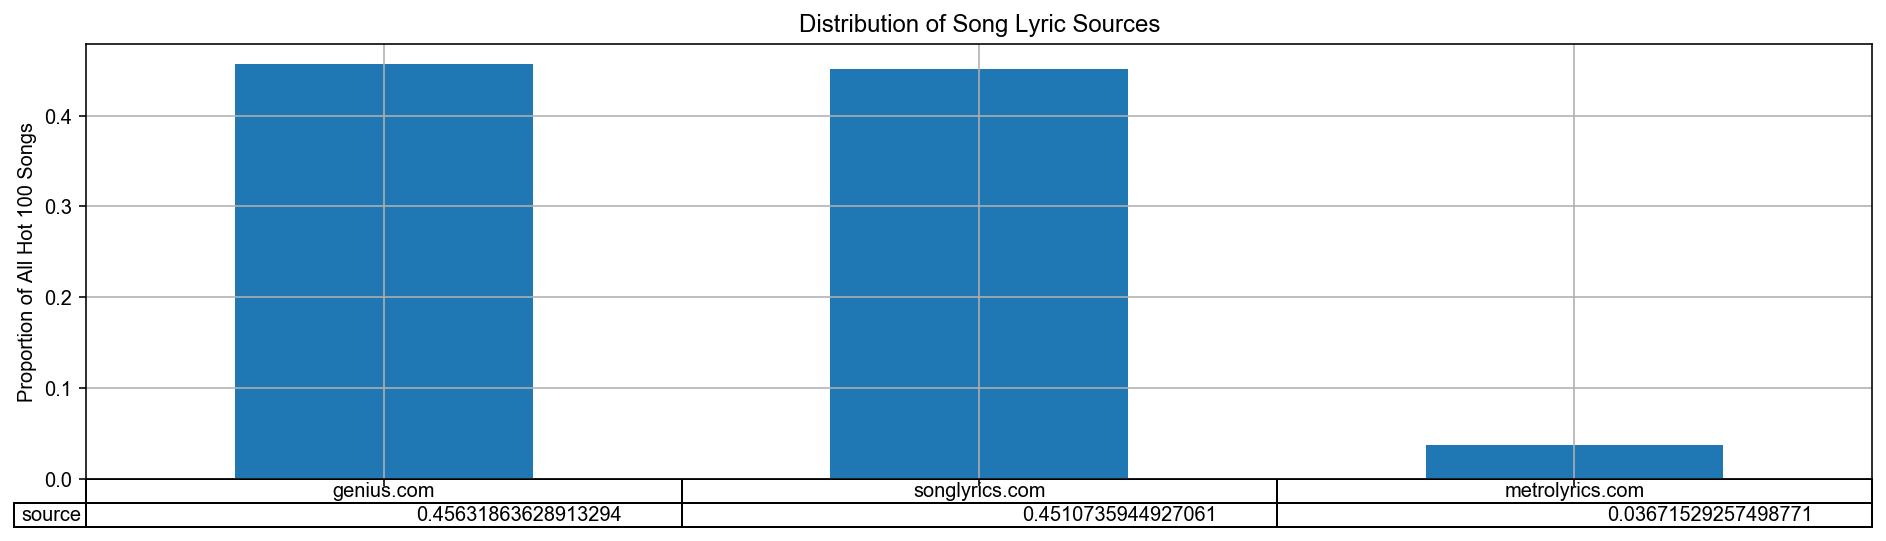

In [8]:
ax = (billboard['source'].value_counts() / len(billboard)).plot.bar(
    table=True, figsize=(16,4))
ax.grid(True)
ax.set_xticklabels([])
ax.set(ylabel='Proportion of All Hot 100 Songs',
       title='Distribution of Song Lyric Sources')

In [ ]:
billboard['lyrics'].isnull().sum() / len(billboard)

In [ ]:
url = 'https://genius.com/marvin-gaye-pride-and-joy-lyrics'
html = requests.get(url=url).content
soup = bs4.BeautifulSoup(html)
lyrics = soup.find('div', {'class': 'lyrics'}).find('p').findAll(text=True)

## Save data

In [ ]:
billboard.to_csv('../data/billboard-lyrics.csv', index=False)